# Survival Analysis and Predicting Patient Cancer Survival with Gene Mutation Data and Clinical Survival Data
###  Washieu Anan

## Version: Complete Analysis. 
There are two other notebooks stored within the 'iterations' folder in this repo. They contain versions of this project focusing on a smaller number of machine learning models. This notebook is more comprehensive and studies the use of multiple more models to determine the best one. This notebook also improves upon previous notebooks in the use of metrics and reusability. Feel free to refer to those previous notebooks to see how the work has progressed. 

Additionally, I would suggest running this code using a service like Google Colaboratory. Some of the models are very computationally intensive (due to the use of GridSearchCV). 



#### Breast cancer survival data from the TCGA holds clues as to what genetic mutations may cause the ultimate fate of patients. In this study, we perform standard survival analysis using  Kaplan Meir Fitter Survival and COX Proportional Hazards, and finally use multiple machine learning models to predict survival of a patient based on their mutations. Two neural networks will also be applied to determine if neural networks are good classifiers for survival predictions. 

## Loading Data from Genomic Data Commons

The National Cancer Institute runs the Genomic Data Commons (GDC), an extremely thorough repository of genomic and clinical data. This is an indispensable data repository for scientists and offers multiple data formats depending on a study of interest. There are many ways to download data from the GDC.

   1. Download directly from the GDC portal. This is perhaps the easiest way to download data as the website interface is very simple, has many filters to help find data quickly, and is also a good way to visualize data. However, for the purpose of demonstrating how data can be downloaded programmatically, this method will not be employed (except to download the clinical .tar file first). Additionally, in the case of downloading multiple datasets, using the website interface can be tedious. 
   2. Using the GDC client. The GDC has a data download tool that can download multiple datasets if one has a manifest file. A manifest file can be downloaded from the GDC portal after selecting what cancer types, file types, and other features one desires. This is very useful if someone wants to download many clinical and mutation files. 
   3. Using the GDC API. The GDC has built an API that can be used with Python to download any file. The file is downloaded onto the user's computer. The user can then access the file from their computer and load it into a kernel.
    
The method that will be used is (3), the GDC API. Since the goal is for multiple cancer types to be potentially examined, the API is a good way to download data programmatically. In order to download desired data, UUIDs will be required. A UUID is a special identification number for any file on the GDC repository. This number can be accessed once clicking on a file on the GDC portal. It can also be accessed from a manifest file if one is to download multiple datasets at a time. 

In this notebook, I will focus on studying Breast Cancer. We will use data collected by the Cancer Genome Atlas project (TCGA). TCGA data is very thorough is used by many bioinformaticians. There are two file types will require for survival analysis and survival prediction: clinical and mutation. The purpose of and data in each file is as follows:

   1. Clinical: clinical files have patient ids (unique alpha-numeric identification key), some patient information like date of birth, vital status (whether patient is alive or dead), days since last follow up or diagnosis, information regarding cancer cells, cancer stage, and information about some possibly related diseases. Many of these files are closed access and can only be obtained if one is given special permission by the NIC. We will only be using open access data. This file does not contain patient's names or locations.

   2. Mutation file: mutation files contain information regarding mutated genes collected from the same patients listed in clinical files. These files have the same patient ids as in clinical files, but focus on mutated genes, site of mutation, type of mutation, region of mutation, and impact of mutation. These datasets are fairly large and contain information regarding some non-relevant mutations. Therefore, some filtering will be employed to only use mutation information for the most prevalent and high impact mutations. 
   
Clinical files can only be retrieved through the portal or by using the GDC client tool. For the purpose of this project, the GDC portal will be used for downloading the clinical files. The mutation files will be downloaded using the API.

In [ ]:
# If you don't already have lifelines, pandas, sckit-learn, tensorflow keras, 
# or xgboost, just run this cell or comment out parts you already have installed 
# and run. Otherwise, skip.
!pip3 install lifelines
!pip3 install pandas
!pip3 install keras
!pip3 install sklearn
!pip3 install xgboost

In [ ]:
'''Import libraries'''

#Essential 
import numpy as np
import requests
import json
import re
import tarfile
import pandas as pd #pandas will help as visualize data
import seaborn as sns #for exploratory data visualization
from matplotlib import pyplot as plt


#Lifelines is a very helpful API for survival analysis. This will help make survival curves.
from lifelines import KaplanMeierFitter
from lifelines import ExponentialFitter
from lifelines import NelsonAalenFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import CoxPHFitter

#Machine learning Models

# XGBoost
import xgboost as xgb #Gradient Boosting Machine

# Keras
from tensorflow.keras.models import Sequential #Neural Network
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# Sklearn
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier #Multi-Layer Perceptron 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, r2_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder #for encoding of categorical data

In [ ]:
# Only run this cell if you are using Google Colabs as suggested. You can easily
# upload the tar.gz file of interest from your machine. If you are not using
# Google Colabs, ensure that the tar.gz file is in directory as this notebook
# or that you know the filepath.
from google.colab import files
cancer_tar_gz = files.upload()

Saving breast_clinical.cases_selection.tar.gz to breast_clinical.cases_selection.tar (1).gz


##### Clinical Files

In [ ]:
'''Clinical files are stored in .tar files by the GDC. The .tar file needs to be extracted to access the CSV file inside. 
Ensure that .tar files from the GDC are in the same working directory. Each .tar file contains a file named 'clinical.tsv' and
a file named 'exposure.tsv'. Thus, it is important to store each file into a seperate dataframe immediately after untarring.
This will ensure the data for different cancer types don't get mixed up or replace each other.'''


# Breast Cancer Clinical File - you can paste in the full file path if 
# file is not in the same directory.
# Untarring
breast_tar = tarfile.open("breast_clinical.cases_selection.tar.gz")
breast_tar.extractall()
breast_tar.close()

#Store in dataframe for breast cancer
clinical_file = 'clinical.tsv'
df_breast = pd.read_csv(clinical_file, sep='\t')


In [ ]:
df_breast.head(3) #Verify that breast clinical data is stored successfully

,case_id,submitter_id,project_id,cause_of_death,gender,year_of_birth,race,days_to_birth,vital_status,days_to_death,ethnicity,year_of_death,ann_arbor_b_symptoms,year_of_diagnosis,classification_of_tumor,last_known_disease_status,method_of_diagnosis,laterality,residual_disease,primary_diagnosis,tumor_stage,age_at_diagnosis,hpv_positive_type,morphology,ann_arbor_clinical_stage,new_event_anatomic_site,days_to_last_known_disease_status,perineural_invasion_present,ajcc_clinical_n,prior_treatment,ajcc_clinical_m,colon_polyps_history,ajcc_pathologic_m,ajcc_pathologic_n,tumor_largest_dimension_diameter,days_to_last_follow_up,ann_arbor_pathologic_stage,days_to_recurrence,tumor_grade,figo_stage,lymphatic_invasion_present,tissue_or_organ_of_origin,progression_or_recurrence,ajcc_clinical_t,hpv_status,prior_malignancy,ajcc_staging_system_edition,vascular_invasion_present,new_event_type,ajcc_pathologic_stage,burkitt_lymphoma_clinical_variant,circumferential_resection_margin,ldh_normal_range_upper,ann_arbor_extranodal_involvement,lymph_nodes_positive,site_of_resection_or_biopsy,ajcc_pathologic_t,days_to_hiv_diagnosis,ajcc_clinical_stage,days_to_new_event,hiv_positive
0,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,TCGA-AR-A24X,TCGA-BRCA,--,female,1954,white,-19030,alive,--,not reported,--,--,--,not reported,not reported,--,--,--,Infiltrating duct and lobular carcinoma,stage iia,19030,--,8522/3,--,--,--,--,--,--,--,--,--,--,--,3004,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
1,31427699-e27a-4035-8925-6d8d6900d097,TCGA-E2-A3DX,TCGA-BRCA,--,female,1968,white,-15969,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Lobular carcinoma, NOS",stage iiic,15969,--,8520/3,--,--,--,--,--,--,--,--,--,--,--,1325,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
2,6cb6f179-defd-4661-af0a-c353b74c0c49,TCGA-A7-A26J,TCGA-BRCA,--,female,1962,white,-17930,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iia,17930,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,627,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--


The breastcancer data has been successfully stored in a dataframe.'TCGA-BRCA' stands for TCGA breast cancer data collected by the TCGA.

##### Mutation Files

In [ ]:
'''Using the GDC's API as well as UUID names for TCGA breast cancer 
mutation files, mutation data is stored in the same directory location as this 
file.'''

pd.set_option('display.max_columns', None) #To see all columns of files in dataframe

#Load Breast Cancer Data   
#Breast Cancer Mutation File
breast_mut_file_id = "995c0111-d90b-4140-bee7-3845436c3b42"
data_endpt = "https://api.gdc.cancer.gov/data/{}".format(breast_mut_file_id)
response = requests.get(data_endpt, headers = {"Content-Type": "application/json"})

# The file name can be found in the header within the Content-Disposition key.
response_head_cd = response.headers["Content-Disposition"]
file_name = re.findall("filename=(.+)", response_head_cd)[0]
with open(file_name, "wb") as output_file:
    output_file.write(response.content)

#Store in pandas dataframe
breast_maf = pd.read_table(file_name, comment='#')    
#Filter the mutation data to get the most prevelant mutations
breast_mut = breast_maf[(breast_maf.FILTER == "PASS") & ((breast_maf.IMPACT == "MODERATE") | (breast_maf.IMPACT == "HIGH"))]

print("{} out of {} mutations passed the filtering criteria for breast cancer, {:.2f}%".format(
    len(breast_mut), len(breast_maf), 100 * len(breast_mut) / len(breast_maf)))

73156 out of 120988 mutations passed the filtering criteria for breast cancer, 60.47%


In [ ]:
breast_mut.head(3) #Verify that breast cancer mutation dataset is stored

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,One_Consequence,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,TRANSCRIPT_STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_Adj,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,CONTEXT,src_vcf_id,tumor_bam_uuid,normal_bam_uuid,case_id,GDC_FILTER,COSMIC,MC3_Overlap,GDC_Validation_Status
1,ERICH3,127254,WUGSC,GRCh38,chr1,74571494,74571494,+,Missense_Mutation,SNP,C,C,T,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.4216G>A,p.Glu1406Lys,p.E1406K,ENST00000326665,14/15,86,42,44,64,NaN,NaN,"ERICH3,missense_variant,p.E1406K,ENST000003266...",T,ENSG00000178965,ENST00000326665,Transcript,missense_variant,missense_variant,4435/7159,4216/4593,1406/1530,E/K,Gag/Aag,NaN,1,NaN,-1.0,ERICH3,HGNC,HGNC:25346,protein_coding,YES,CCDS30755.1,ENSP00000322609,Q5RHP9,NaN,UPI0000237200,NM_001002912.4,deleterious(0.01),possibly_damaging(0.833),14/15,NaN,PROSITE_profiles:PS50313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,5.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,TTCCTCTACCA,d083d669-6646-463b-853e-c58da8d06439,4374e19d-c5e7-49cf-8707-05ae5aeb7369,aadee87c-6a68-4580-bd10-64ac273b1e3d,0130d616-885e-4a6c-9d03-2f17dd692a05,NaN,COSM1474194,True,Unknown
6,FN1,2335,WUGSC,GRCh38,chr2,215397809,215397809,+,Nonsense_Mutation,SNP,C,C,A,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.3388G>T,p.Glu1130Ter,p.E1130*,ENST00000359671,22/45,94,77,17,106,NaN,NaN,"FN1,stop_gained,p.E1130*,ENST00000354785,NM_21...",A,ENSG00000115414,ENST00000359671,Transcript,stop_gained,stop_gained,3654/8524,3388/7161,1130/2386,E/*,Gaa/Taa,NaN,1,NaN,-1.0,FN1,HGNC,HGNC:3778,protein_coding,NaN,NaN,ENSP00000352696,P02751,NaN,UPI00001AEBF3,NaN,NaN,NaN,22/45,NaN,Pfam_domain:PF00041;PROSITE_profiles:PS50853;S...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIGH,NaN,SNV,5.0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,CACTTCTCGTG,d083d669-6646-463b-853e-c58da8d06439,4374e19d-c5e7-49cf-8707-05ae5aeb7369,aadee87c-6a68-4580-bd10-64ac273b1e3d,0130d616-885e-4a6c-9d03-2f17dd692a05,NaN,COSM1482746;COSM1482747,True,Unknown
7,SPHKAP,80309,WUGSC,GRCh38,chr2,228016738,228016738,+,Missense_Mutation,SNP,C,C,A,NaN,NaN,TCGA-D8-A1XY-01A-11D-A14K-09,TCGA-D8-A1XY-10A-01D-A14K-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somatic,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,edb6d161-8f50-4c11-8246-487c4ea9a55d,8dea96d9-5017-4872-a84e-33bfd2f37b7a,c.4116G>T,p.Arg1372Ser,p.R1372S,ENST00000392056,7/12,74,61,13,61,NaN,NaN,"SPHKAP,missense_variant,p.R1372S,ENST000003920...

All data has been successfully downloaded and stored into seperate, unique dataframes. This proves that clinical and mutation data available on the GDC can be programatically downloaded (with the exception of having to physically download the clinical .tar file from the GDC portal or by using the GDC client). Additionally, the mutation dataset was filtered to find the most prevelant mutations in the list. 

## Breast Cancer Survival Analysis 

The breast cancer data will be studied. Survival analysis will allow us to see how gene mutations and cancer stage ultimately impact survival of a patient over time. 

In [ ]:
'''
Since, we are dealing with breast cancer, we should really focus on the TP53 and PIK3CA genes. We can find the mutation 
load of each gene and we will see that the TP53 and PIK3CA genehave the highest load. Within the breast_mut dataframe, 
one can find many column names. Here are some very relevant ones

Hugo_Symbol: name of the gene

Entrez_Gene_id: id of the gene, similar to Hugo_Symbol

case_id: patient case id associated with patients in the clinical file; this will allow us to merge the mutations and clinical
dataframes for each unique patient

Tumor_Sample_Barcode: unique barcode for the dataset
'''

#Let's show the frequency of each unique mutation in our mutation dataset
mutation_frequency_breast = breast_mut.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency_breast.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency_breast.head(10)

,Hugo_Symbol,Tumor_Sample_Barcode
14207,TP53,325
10175,PIK3CA,323
14595,TTN,184
2338,CDH1,132
5145,GATA3,129
8415,MUC16,111
7076,KMT2C,90
7760,MAP3K1,79
11836,RYR2,63
5967,HMCN1,61


As we can see, the TP53 and PIK3CA genes are the most prevenlently mutated genes associated with breast cancer. Thus, our focus will be on these genes. The importance of the genes in breast cancer has been shown in cancer studies as well. G et al. in "Prevalence and spectrum of AKT1, PIK3CA, PTEN and TP53 somatic mutations in Chinese breast cancer patients" discusses these two genes with regards to their impact on breast cancer in depth [1].

In [ ]:
'''Not every column in the mutation dataframe is relevant to us. We care about the mutation name and id, as well as the
case id of the patient that mutation. This is because want to see the impact of the gene mutation itself on patient survival
time. Other features can be used from this mutation dataset for future studies.'''

#Let's take parts of the mutation set that are most relevant going forward. Let's store it in a new dataframe called relmut
breast_relmut = breast_mut[['Hugo_Symbol', 'Entrez_Gene_Id', 'case_id', 'Tumor_Sample_Barcode']]
breast_relmut.head()

,Hugo_Symbol,Entrez_Gene_Id,case_id,Tumor_Sample_Barcode
1,ERICH3,127254,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
6,FN1,2335,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
7,SPHKAP,80309,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
8,HRH1,3269,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09
11,PIK3CA,5290,0130d616-885e-4a6c-9d03-2f17dd692a05,TCGA-D8-A1XY-01A-11D-A14K-09


In [ ]:
'''Now, lets move onto understanding the clinical file. However, we want to make sure that we analyze patient data for patients
who also show up in the mutation dataset. Otherwise, we may have missing values in some columns for some patients. This may occur
due to our filtering of the mutation dataset for high impact mutations.'''

#You will notice that there are case ids in this mutation file. These case ids correspond to the case ids in our clinical file.
#We want to find the instances in our clinical file that are also part of the mutation file.
cID = breast_relmut.case_id.tolist() #let's store the case ids inside a list
df_breast = df_breast[df_breast['case_id'].isin(cID)] #Now let's filter our clinical file dataframe with the case ids also in relmut
df_breast.head()

,case_id,submitter_id,project_id,cause_of_death,gender,year_of_birth,race,days_to_birth,vital_status,days_to_death,ethnicity,year_of_death,ann_arbor_b_symptoms,year_of_diagnosis,classification_of_tumor,last_known_disease_status,method_of_diagnosis,laterality,residual_disease,primary_diagnosis,tumor_stage,age_at_diagnosis,hpv_positive_type,morphology,ann_arbor_clinical_stage,new_event_anatomic_site,days_to_last_known_disease_status,perineural_invasion_present,ajcc_clinical_n,prior_treatment,ajcc_clinical_m,colon_polyps_history,ajcc_pathologic_m,ajcc_pathologic_n,tumor_largest_dimension_diameter,days_to_last_follow_up,ann_arbor_pathologic_stage,days_to_recurrence,tumor_grade,figo_stage,lymphatic_invasion_present,tissue_or_organ_of_origin,progression_or_recurrence,ajcc_clinical_t,hpv_status,prior_malignancy,ajcc_staging_system_edition,vascular_invasion_present,new_event_type,ajcc_pathologic_stage,burkitt_lymphoma_clinical_variant,circumferential_resection_margin,ldh_normal_range_upper,ann_arbor_extranodal_involvement,lymph_nodes_positive,site_of_resection_or_biopsy,ajcc_pathologic_t,days_to_hiv_diagnosis,ajcc_clinical_stage,days_to_new_event,hiv_positive
0,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,TCGA-AR-A24X,TCGA-BRCA,--,female,1954,white,-19030,alive,--,not reported,--,--,--,not reported,not reported,--,--,--,Infiltrating duct and lobular carcinoma,stage iia,19030,--,8522/3,--,--,--,--,--,--,--,--,--,--,--,3004,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
2,6cb6f179-defd-4661-af0a-c353b74c0c49,TCGA-A7-A26J,TCGA-BRCA,--,female,1962,white,-17930,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iia,17930,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,627,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
4,b8a44fdf-9cb9-4123-9ab0-4bc198921fee,TCGA-OL-A5RU,TCGA-BRCA,--,female,1947,black or african american,-23108,alive,--,not reported,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iia,23108,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,1219,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
5,24e39609-9645-43e5-960b-db5446eaea65,TCGA-E2-A154,TCGA-BRCA,--,female,1941,white,-24999,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage i,24999,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,591,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--
6,8631969d-4ac6-4fe1-9db3-d47db604494a,TCGA-E9-A1R2,TCGA-BRCA,--,female,1960,white,-18936,alive,--,not hispanic or latino,--,--,--,not reported,not reported,--,--,--,"Infiltrating duct carcinoma, NOS",stage iiic,18936,--,8500/3,--,--,--,--,--,--,--,--,--,--,--,1063,--,--,not reported,--,--,"Breast, NOS",not reported,--,--,not reported,--,--,--,--,--,--,--,--,--,"Breast, NOS",--,--,--,--,--


You may notice many columns have missing values or are simply not reported. For suvival analysis, we only really need two pieces of information:

1. Vital status: we need to know if the patient is alive or dead at the conclusion of this study in which this data was collected. 
2. Cancer duration: this is the amount of time that has passed from cancer diagnosis to death ('days_to_death' column) or the amount of time that has passed from the most recent followup appointment ('days_to_last_follow_up' column). We need to consolidate these columns into one 'duration' column. 
3. Tumor stage: since the stage of the tumor at the end of the study is of interest to us for the machine learning portion of the project in which survival prediction will be done, we need to extract that infomration as well.

In [ ]:
#As shown in the pandas dataframe for the clinical file, we have multiple fields of information for each patient sample. 
#However, we are particularly interested in the days to death or days to last follow up and the vital status of the patients.
#When we have found those particular fields and isolated them, we can begin to modify the table by simplifying the 
#vital status for the use of survival regression studies.

#Let's modify the data set to only have the particular columns we want
df_breast_1 = df_breast[['case_id', 'vital_status', 'days_to_death', 'days_to_last_follow_up', 'tumor_stage', 'age_at_diagnosis', 'primary_diagnosis']]
df_breast_1.head()

,case_id,vital_status,days_to_death,days_to_last_follow_up,tumor_stage,age_at_diagnosis,primary_diagnosis
0,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,alive,--,3004,stage iia,19030,Infiltrating duct and lobular carcinoma
2,6cb6f179-defd-4661-af0a-c353b74c0c49,alive,--,627,stage iia,17930,"Infiltrating duct carcinoma, NOS"
4,b8a44fdf-9cb9-4123-9ab0-4bc198921fee,alive,--,1219,stage iia,23108,"Infiltrating duct carcinoma, NOS"
5,24e39609-9645-43e5-960b-db5446eaea65,alive,--,591,stage i,24999,"Infiltrating duct carcinoma, NOS"
6,8631969d-4ac6-4fe1-9db3-d47db604494a,alive,--,1063,stage iiic,18936,"Infiltrating duct carcinoma, NOS"


In [ ]:
#Examine how many patients will be studied
print('Total patients in dataset: ' + str(len(df_breast_1)))

Total patients in dataset: 985


In [ ]:
#The days_to_death and days_to_last_follow_up column is our duration information. We want to consolidate that information
#into one duration set. Using pandas column manipulation, we can do just that. Additionally, we should set the vital_status info
#into integers based on dead or alive status. Alive will be a 0, while dead will be a 1.

df2 = df_breast_1 #We want to modify the table but without tampering with it
df2.days_to_death[df2.days_to_death == '--'] = df2.days_to_last_follow_up #Get rid of empty rows in the days_to_death column
df2['duration'] = df2['days_to_death'] #copy all values into one duration column
df3 = df2[['case_id','vital_status', 'duration', 'tumor_stage', 'age_at_diagnosis', 'primary_diagnosis' ]] #df3 is the dataframe with our ultimate data
df3.vital_status[df3.vital_status == 'alive'] = 0 #making vital_status into 0 or 1 based on status
df3.vital_status[df3.vital_status == 'dead'] = 1
df3 = df3[df3['duration'] != '--'] #Takes care of any missing duration rows

In [ ]:
#The duration and vital_status needs to be converted to a numeric for further use
df3['duration'] = pd.to_numeric(df3['duration'])
df3 = df3[df3['duration'] > 0] # take care of any non-positive durations by removing them
df3['vital_status'] = pd.to_numeric(df3['vital_status'])
df3.head()

,case_id,vital_status,duration,tumor_stage,age_at_diagnosis,primary_diagnosis
0,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia,19030,Infiltrating duct and lobular carcinoma
2,6cb6f179-defd-4661-af0a-c353b74c0c49,0,627,stage iia,17930,"Infiltrating duct carcinoma, NOS"
4,b8a44fdf-9cb9-4123-9ab0-4bc198921fee,0,1219,stage iia,23108,"Infiltrating duct carcinoma, NOS"
5,24e39609-9645-43e5-960b-db5446eaea65,0,591,stage i,24999,"Infiltrating duct carcinoma, NOS"
6,8631969d-4ac6-4fe1-9db3-d47db604494a,0,1063,stage iiic,18936,"Infiltrating duct carcinoma, NOS"


As shown above, the 'duration' field is a consolidated patient survival duration column. This will allow for a simple survival analysis. However, we are interested in survival analysis for patients based on their gene mutation as well. Thus, we will need to now merge the mutation and clinical dataframes.

In [ ]:
#We can now find the intersection between the mutation dataset and the clinical file by merging the two based 
#on the case_id field. 
df3 = pd.merge(df3, breast_relmut, on='case_id', how='inner')
df3.head()

,case_id,vital_status,duration,tumor_stage,age_at_diagnosis,primary_diagnosis,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode
0,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia,19030,Infiltrating duct and lobular carcinoma,ARID1A,8289,TCGA-AR-A24X-01A-11D-A167-09
1,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia,19030,Infiltrating duct and lobular carcinoma,MAST2,23139,TCGA-AR-A24X-01A-11D-A167-09
2,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia,19030,Infiltrating duct and lobular carcinoma,PLEKHH2,130271,TCGA-AR-A24X-01A-11D-A167-09
3,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia,19030,Infiltrating duct and lobular carcinoma,ACPP,55,TCGA-AR-A24X-01A-11D-A167-09
4,491d5ebb-e9ab-4b17-acb8-630ff9fef0f2,0,3004,stage iia,19030,Infiltrating duct and lobular carcinoma,SI,6476,TCGA-AR-A24X-01A-11D-A167-09


In [ ]:
#Let us confirm using the mutation frequency that the most common genes we should worry about are TP53 and PIK3CA, just
#this time with our combined dataframe with muatation info, duration, and vital_status. As you can see, those two genes
#are still most prevalent.
mutation_frequency_breast = df3.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency_breast.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency_breast.head(10)

,Hugo_Symbol,Tumor_Sample_Barcode
14123,TP53,320
10121,PIK3CA,319
14505,TTN,182
2327,CDH1,132
5122,GATA3,126
8365,MUC16,109
7040,KMT2C,87
7718,MAP3K1,78
11764,RYR2,62
5938,HMCN1,60


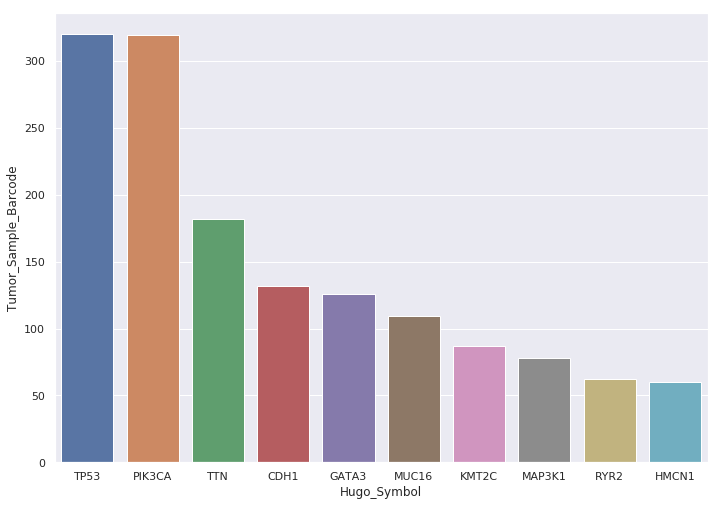

In [ ]:
#Let's visualize this to showcase how important each gene probably is compared to other genes in the top 10 most prevelant genes
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x = 'Hugo_Symbol', y = 'Tumor_Sample_Barcode', data = mutation_frequency_breast[0:10])


In [ ]:
#Just as an extra check, we can even see if those two genes are common amongst patients who passed away.
df3_test_one = df3[df3['vital_status'] == 1]
mutation_frequency_test_one = df3_test_one.groupby("Hugo_Symbol")["Tumor_Sample_Barcode"].nunique().reset_index()
mutation_frequency_test_one.sort_values("Tumor_Sample_Barcode", ascending=False, inplace=True)
mutation_frequency_test_one.head()

,Hugo_Symbol,Tumor_Sample_Barcode
6170,TP53,51
4414,PIK3CA,42
6320,TTN,28
2227,GATA3,20
3081,KMT2C,18


In [ ]:
#Since we can see that the TP53 and PIK3CA genes are the most important genes for breast cancer status, let's filter our
#combined clinical/mutation dataset for cases with these mutations. However, we want to see how a less prevelant gene
#affects patient survival as well so as to highlight the biffer effect of the TP53 and PIK3CA genes on breast cancer patient 
#survival. Thus, let's pick the 10th most prevelant gene in our filtered dataset: HMCN1
common = ['TP53', 'PIK3CA', 'HMCN1'] #store the important genes in a list
df3 = df3[df3['Hugo_Symbol'].isin(common)] #filter the dataframe with the two genes inside the list common
df3.head()

,case_id,vital_status,duration,tumor_stage,age_at_diagnosis,primary_diagnosis,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode
83,24e39609-9645-43e5-960b-db5446eaea65,0,591,stage i,24999,"Infiltrating duct carcinoma, NOS",PIK3CA,5290,TCGA-E2-A154-01A-11D-A10Y-09
343,a6edb6ca-ae9f-4da7-8ebe-92d83d2987fb,0,450,stage iia,15903,"Infiltrating duct carcinoma, NOS",TP53,7157,TCGA-E2-A158-01A-11D-A12B-09
368,491b6364-1223-474f-816f-e248c8c841e2,0,1156,stage iib,23366,"Infiltrating duct carcinoma, NOS",HMCN1,83872,TCGA-BH-A0DH-01A-11D-A099-09
408,298a1710-deb4-4064-a0f2-da32d43aa217,0,1476,stage iib,--,"Infiltrating duct carcinoma, NOS",PIK3CA,5290,TCGA-C8-A12Y-01A-11D-A12B-09
486,4fba3deb-db94-44b5-a0f2-a575d270779e,0,1174,stage iia,22686,"Infiltrating duct carcinoma, NOS",HMCN1,83872,TCGA-E2-A14R-01A-11D-A10Y-09


In [ ]:
#Let's see how many patienst we will be studying
print('Patients in analysis: ' + str(len(df3)))

Patients in analysis: 748


Text(0.5, 1.0, 'Breast Cancer Patient Survival Duration Distriburtion')

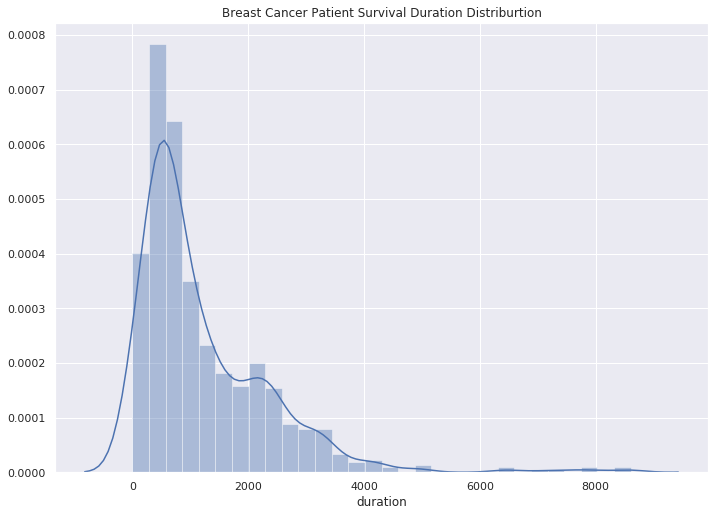

In [ ]:
#Let us see the distribruation of the duration
durationsxx = df3['duration']
sns.distplot(durationsxx).set_title('Breast Cancer Patient Survival Duration Distriburtion')

### Plotting Survival Curves - Censorship

Now, we can begin plotting survival curves. These curves shows the fractions of patients alive as time passes onto the end of the study. We need to understand something important about our data first, however. In our dataset, we don't know exactly when all of the patients die. Some of the patients in our dataset survive past the time the data stopped being collected. Thus, we are dealing with *right-censored* data. This is an important consideration to take into account when making survival curves and hazard curves.

Additionally, it is important to realize that for every gene mutation, we may not see survival curves for each mutation of interest complete to the end of total duration. For example, the survival curve for one mutation may end abruptly before the end of the study period. This is either because no more patients with that particular died after a certain point in the study or patient data for patients with that gene mutation stopped being collected.

Text(0, 0.5, 'Fraction of Patients Alive')

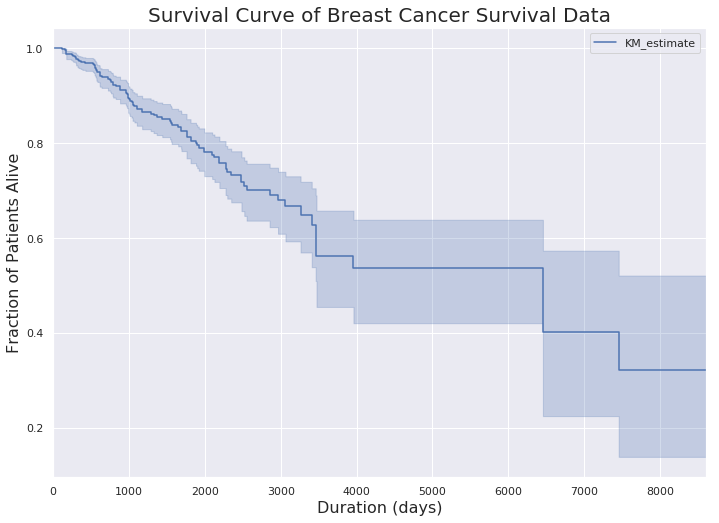

In [ ]:
'''We can start performing survival analysis. We can use the Kaplan-Meier Estimate from the liflines module.
We can also find the cumulative density function of our dataset based on the two important genes.'''

#Let's make a Kaplan Meier Fitter Survival curve for the entire data set
T = df3['duration'] #we store the duration information in the dataframe T
E = df3['vital_status'] #we store the vital_status information in the dataframe E

#We will pass these dataframes to the Kaplan-Meier Estimate fitter
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  
kmf.survival_function_
kmf.median_
kmf.plot()
plt.title('Survival Curve of Breast Cancer Survival Data', fontsize=20)
plt.xlabel('Duration (days)', fontsize=16)
plt.ylabel('Fraction of Patients Alive', fontsize=16)

Text(0, 0.5, 'Fraction of Patients Alive')

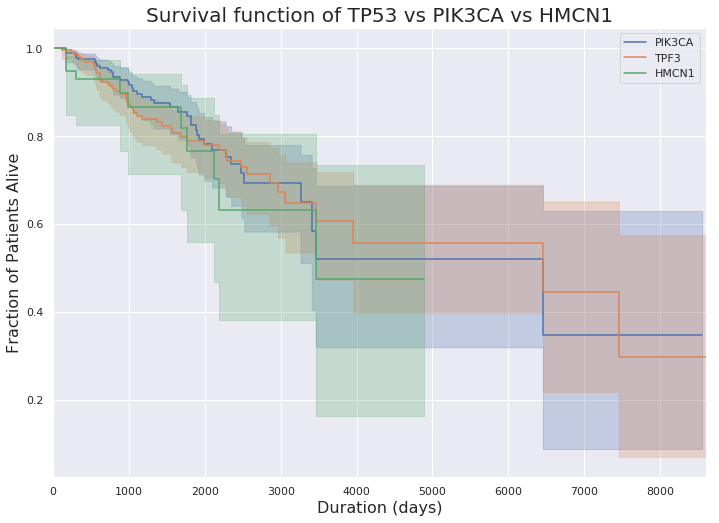

In [ ]:
#Now lets plot the KMF survival curves per mutated gene. We will go ahead and plot the survival curve for each mutated gene
#and also compare them in one survival graph.
groups = df3['Hugo_Symbol'] #groups is a dataframe with the gene names

#Make the survival curve comparing TP53 gene against PIK3CA
tp53 = (groups == 'TP53')
pik = (groups == 'PIK3CA')
hmc = (groups == 'HMCN1')

kmf.fit(T[pik], E[pik], label='PIK3CA')
ax = kmf.plot()
kmf.fit(T[tp53], E[tp53], label='TPF3')
ax = kmf.plot(ax=ax)
kmf.fit(T[hmc], E[hmc], label='HMCN1')
ax = kmf.plot(ax=ax)
plt.title('Survival function of TP53 vs PIK3CA vs HMCN1', fontsize=20)
plt.xlabel('Duration (days)', fontsize=16)
plt.ylabel('Fraction of Patients Alive', fontsize=16)

This is a clear example of what to expect with right censored data! As we can see, patients with the HMCN1 mutation show a survival curve that abruptly ends before the two other gene mutations. This may mean that no more patients with the HMCN1 gene mutation died or that data for patients with that gene mutation were no longer being checked on by those who collected this data.

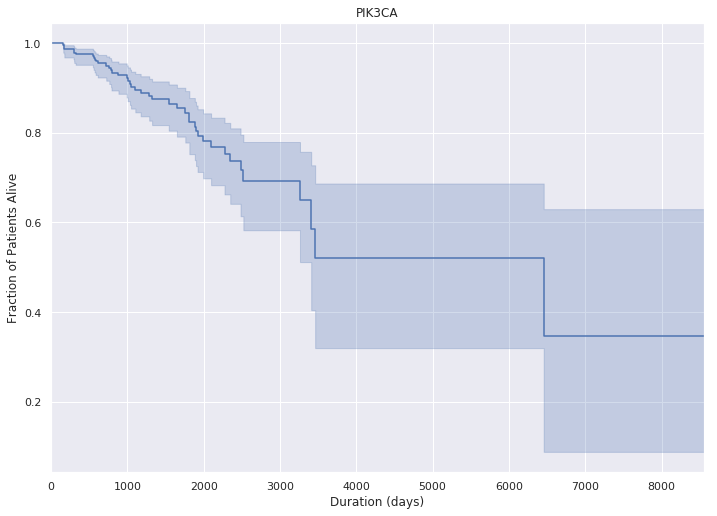

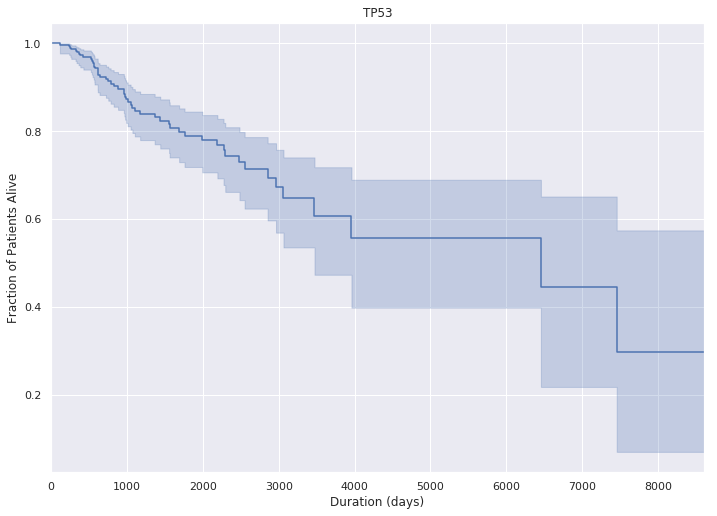

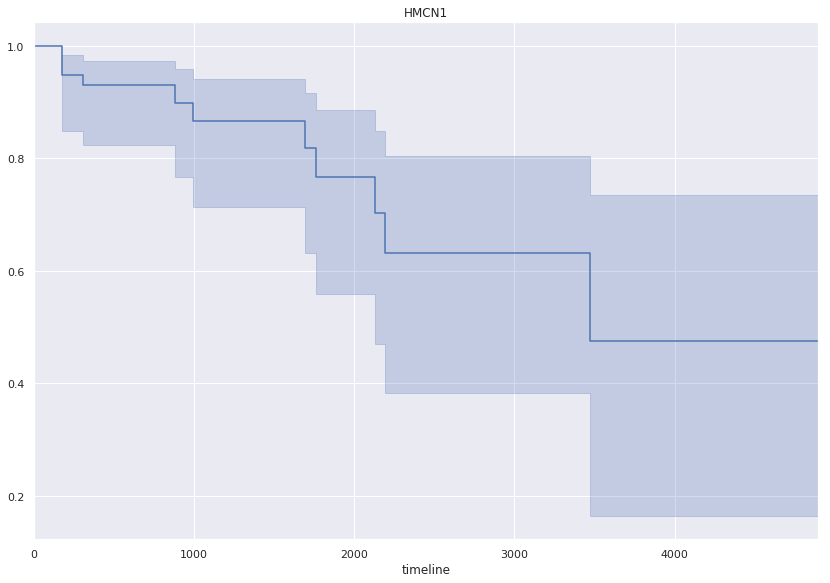

In [ ]:
#We can also visualize them seperately.
mutgenes = df3['Hugo_Symbol'].unique()

for i,mg in enumerate(mutgenes):
 
    ix = df3['Hugo_Symbol'] == mg
    kmf.fit( T[ix], E[ix], label=mg)
    kmf.plot(legend=False)
    plt.title(mg)
    if i==0:
        plt.ylabel('Fraction of Patients Alive')
        plt.xlabel("Duration (days)")
    elif i==1:
        plt.ylabel('Fraction of Patients Alive')
        plt.xlabel("Duration (days)")
plt.tight_layout()

### Plotting Hazard Curves

Now let us plot the cumulative density function for our data set. This is the hazard function of our dataset, displaying the hazard or chance of death as time goes on. We don't witness the onset of the cancer, we only know how longthe patient has been alive or dead, so this is a good estimate of the hazard.

As can be seen below, as time passes on, the hazard of death, or the chance of death significantly rises.

Text(0.5, 1.0, 'Cumulative Density Function/Hazard Curve')

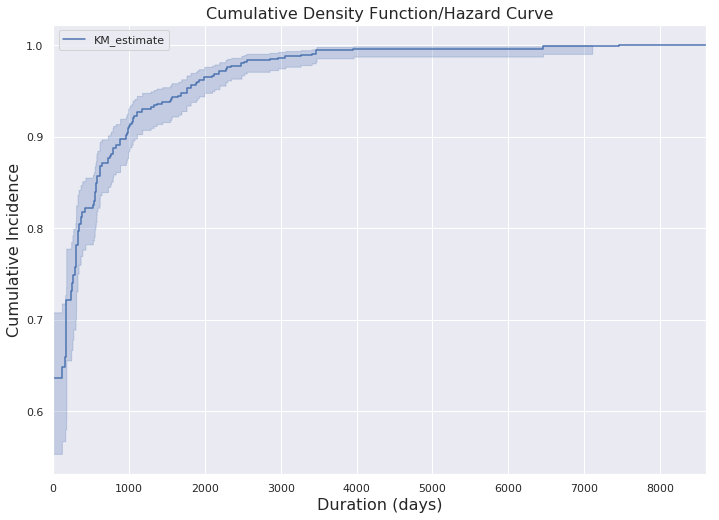

In [ ]:
#Kaplan Meier Fitter plots hazard functions for survival studies
kmf = KaplanMeierFitter()
kmf.fit_left_censoring(T, E)
kmf.plot() #will plot the CDF
plt.xlabel("Duration (days)", fontsize=16)
plt.ylabel('Cumulative Incidence', fontsize=16)
plt.title("Cumulative Density Function/Hazard Curve", fontsize=16)

Text(0, 0.5, 'Cumulative Incidence')

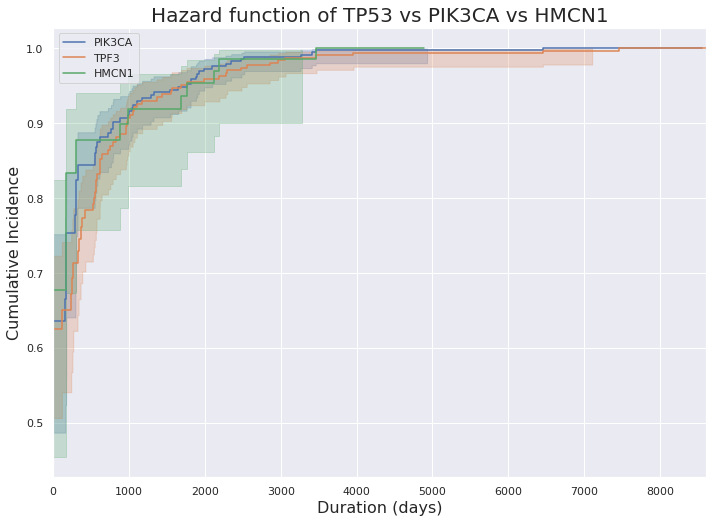

In [ ]:
kmf.fit_left_censoring(T[pik], E[pik], label='PIK3CA')
ax = kmf.plot()
kmf.fit_left_censoring(T[tp53], E[tp53], label='TPF3')
ax = kmf.plot(ax=ax)
kmf.fit_left_censoring(T[hmc], E[hmc], label='HMCN1')
ax = kmf.plot(ax=ax)
plt.title('Hazard function of TP53 vs PIK3CA vs HMCN1', fontsize=20)
plt.xlabel("Duration (days)", fontsize=16)
plt.ylabel('Cumulative Incidence', fontsize=16)

As we can see, the three genes seem to show similar hazard curves. However, notice that the error for the HMCN1 curve is much larger than that of PIK3CA and TP53. This is probably because HMCN1's effect on patient survival varies much more greatly from patient to patient. Also notice, the curve end abruptly. It is interesting that the hazard functions are similar for all three gene mutations. This suggests that although TP53 and PIK3CA are the most prevelant gene mutations in patients with breast cancer, they aren't necessarily the most important gene mutation leading to death for every patient. This hazard curve may suggest that the HMCN1 gene mutation may actually have as much of an effect on breast cancer patient survival as PIK3CA and TP53!  Interestingly, Kikutake et al., in "Intratumor heterogeneity of HMCN1 mutant alleles associated with poor prognosis in patients with breast cancer" identified that the HMCN1 gene may be very important for breast cancer cell metastisis and may be a good candidate for breast cancer therapy [2].

Thus, our survival analysis has allowed us to see the effects of three mutated genes on breast cancer patient survival. We knew that the PIK3CA and TP53 gene mutations are most prevalent. However, our analysis showed us that the much less prevelant mutation HMCN1 may also be of importance. Therefore, it important to also further study the effect of the HMCN1 gene mutation on breast cancer. We were able to use patient clinical data and mutation data to come to this important conclusion.


In [ ]:
'''In this section, we apply a COX regression model to see if there is an assocation with survival
time of patients and their mutated gene.'''

#COX Regression Analysis
from lifelines import CoxPHFitter
df4 = df3[['Entrez_Gene_Id', 'duration', 'vital_status']]
cph = CoxPHFitter()
cph.fit(df4, duration_col='duration', event_col='vital_status', show_progress=True)

cph.print_summary()  #results


Iteration 4: norm_delta = 0.00001, step_size = 1.0000, ll = -586.20728, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 4 iterations.
<lifelines.CoxPHFitter: fitted with 748 observations, 641 censored>
      duration col = 'duration'
         event col = 'vital_status'
number of subjects = 748
  number of events = 107
partial log-likelihood = -586.21
  time fit was run = 2019-09-09 01:36:38 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
Entrez_Gene_Id  0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                  z    p  -log2(p)
Entrez_Gene_Id 0.71 0.48      1.06
---
Concordance = 0.54
Log-likelihood ratio test = 0.47 on 1 df, -log2(p)=1.02


As can be seen, the p value is really high. The concordance is also close to .5. This means that regardless of the TP53, PIK3CA, or HMCN1 gene mutation, one generally has a random chance of determining the survival status of the breast cancer patient. This is in agreement with the conclusions we made earlier using curvival and hazard curves.

# Machine Learning: Breast Cancer Survival Prediction

Now, we will make a few machine learning models to predict breast cancer patient survival. The purpose of this study is to determine if we can use patient tumor stage, duration, gene mutation type. and age at diagnosis to predict vital status. The value of this study is that it allows for us to determine whether or not a patient is expected to survive given their tumor stage and gene mutation. This is very important in clinical settings because it may ultimately impact the administration of life saving medications and save lives. 

Note: Since we want to determine patient survival, we are dealing with a classification problem and not a regression one. 

Multiple machine learning approaches will be utilized. Note that in the original notebooks in the 'preliminary project' folder, only gradient boosting, multilayer peceptron, and a keras neural network were used. Here, we apply multiple models. This was done after my internship at Veta Health.



These models are: 
>  [K Nearest Neighbors Classifier](https://scikitlearn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) 

>  [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) 

>  [Logistic Regression Classifier](https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 

>  [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)  

>  [Gaussian Naive-Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

>  [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) 

>  [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). 

>  [Multilayer Perceptron Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

>  [XGBoost](https://xgboost.readthedocs.io/en/latest/)

>  [Keras (not a model, but a library used to make neural networks)](https://keras.io)


[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html): For all of these models, except for the neural network, I applied GridSearchCV. GridSearchCV goes through many different combinations of parameters before deciding on the ideal one. This will ensure that the model is finely tuned for each unique dataset.

#### A note on metrics

Whereas with regression, one may use metrics such as mean squared error or mean absolute error to quantity the performance of their models, one uses other metrics with classification. As noted, we will be using the F1 score, recall, precision, classification accuracy, and AUC-ROC. These metrics revolve around counting the number of correct classifications and the number of incorrect classifications, and then relating those values to the rest of the classifications. For a in-depth overview of these metrics, refer to the following well written [article](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2).

In our case:

* Precision: For each class, the number of correctly predicted classes out of all predictions for that class.

* Recall: For each class, the number of correct predictions out the actual number of instances belonging to that class.

* F1-Score: 2 × (precision × recall)/(precision + recall)

The precision, recall, and F1-score for each class is calculated after running our models and making predictions. We also perform the accuracy metric, just to show the number of accurate predictions out of all predictions. We also find the AUC-ROC, or area under the reciever operating characteristic curve. An AUC-ROC closer to 0.5 means that our classifier is unable to differentiate between our classes and a AUC-ROC closer to 1.0 suggests that we have a good binary classifier.

### Extra Data Processing

Most machine learning models, including neural networks, can't work with strings. Note that the 'tumor_stage" column and "Hugo_Symbol" or "Entrez_Gene_Id" fields are also string values. Thus, they must be encoded into numbers for use in our models. Additionally, the duration time must converted to negative values for patients who are alive as positive values for duration are only meant for patients who have died. This is because the duration is means how much time has passed since death. This distinction wasn't important for our survival analysis as the lifelines library we used is able to interpret this information given vital_status. Our models won't be able to do this, so we need to preprocess our dataset to ensure our data represents proper duration times. 

In [ ]:
#Notice that the duration time for both alive and dead patients are positive.
# Since those patients haven't completed the 'duration' field, we will represent 
# them with negative durations.
df3a = df3
df3a.loc[df3a['vital_status'] == 0, 'duration'] *= -1
df3a.head()

,case_id,vital_status,duration,tumor_stage,age_at_diagnosis,primary_diagnosis,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode
83,24e39609-9645-43e5-960b-db5446eaea65,0,-591,stage i,24999,"Infiltrating duct carcinoma, NOS",PIK3CA,5290,TCGA-E2-A154-01A-11D-A10Y-09
343,a6edb6ca-ae9f-4da7-8ebe-92d83d2987fb,0,-450,stage iia,15903,"Infiltrating duct carcinoma, NOS",TP53,7157,TCGA-E2-A158-01A-11D-A12B-09
368,491b6364-1223-474f-816f-e248c8c841e2,0,-1156,stage iib,23366,"Infiltrating duct carcinoma, NOS",HMCN1,83872,TCGA-BH-A0DH-01A-11D-A099-09
408,298a1710-deb4-4064-a0f2-da32d43aa217,0,-1476,stage iib,--,"Infiltrating duct carcinoma, NOS",PIK3CA,5290,TCGA-C8-A12Y-01A-11D-A12B-09
486,4fba3deb-db94-44b5-a0f2-a575d270779e,0,-1174,stage iia,22686,"Infiltrating duct carcinoma, NOS",HMCN1,83872,TCGA-E2-A14R-01A-11D-A10Y-09


In [ ]:
# We will one-hot encode our categorical features 

# tumor_stage
df3a['tumor_stage'] = pd.Categorical(df3a['tumor_stage'])
tumor_stage_enc = pd.get_dummies(df3a['tumor_stage'], prefix = 'tumor_stage')
df3a  = pd.concat([df3a, tumor_stage_enc], axis=1)

#primary_diagnosis
df3a['primary_diagnosis'] = pd.Categorical(df3a['primary_diagnosis'])
primdiag_enc = pd.get_dummies(df3a['primary_diagnosis'], prefix = 'primary_diagnosis')
df3a  = pd.concat([df3a, primdiag_enc], axis=1)

#Hugo_Symbol
df3a['Hugo_Symbol'] = pd.Categorical(df3a['Hugo_Symbol'])
hugo_enc = pd.get_dummies(df3a['Hugo_Symbol'], prefix = 'Hugo_Symbol')
df3a  = pd.concat([df3a, hugo_enc], axis=1)

In [ ]:
df3a.head(1)

,case_id,vital_status,duration,tumor_stage,age_at_diagnosis,primary_diagnosis,Hugo_Symbol,Entrez_Gene_Id,Tumor_Sample_Barcode,tumor_stage_not reported,tumor_stage_stage i,tumor_stage_stage ia,tumor_stage_stage ib,tumor_stage_stage ii,tumor_stage_stage iia,tumor_stage_stage iib,tumor_stage_stage iii,tumor_stage_stage iiia,tumor_stage_stage iiib,tumor_stage_stage iiic,tumor_stage_stage iv,tumor_stage_stage x,primary_diagnosis_Apocrine adenocarcinoma,primary_diagnosis_Infiltrating duct and lobular carcinoma,"primary_diagnosis_Infiltrating duct carcinoma, NOS",primary_diagnosis_Infiltrating duct mixed with other types of carcinoma,primary_diagnosis_Infiltrating lobular mixed with other types of carcinoma,primary_diagnosis_Intraductal micropapillary carcinoma,primary_diagnosis_Intraductal papillary adenocarcinoma with invasion,primary_diagnosis_Large cell neuroendocrine carcinoma,"primary_diagnosis_Lobular carcinoma, NOS","primary_diagnosis_Medullary carcinoma, NOS","primary_diagnosis_Metaplastic carcinoma, NOS",primary_diagnosis_Mucinous adenocarcinoma,primary_diagnosis_Paget disease and infiltrating duct carcinoma of breast,"primary_diagnosis_Papillary carcinoma, NOS",primary_diagnosis_Pleomorphic carcinoma,primary_diagnosis_Tubular adenocarcinoma,Hugo_Symbol_HMCN1,Hugo_Symbol_PIK3CA,Hugo_Symbol_TP53
83,24e39609-9645-43e5-960b-db5446eaea65,0,-591,stage i,24999,"Infiltrating duct carcinoma, NOS",PIK3CA,5290,TCGA-E2-A154-01A-11D-A10Y-09,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:

# Get names of indexes for which column Age has value 30
miss_age = df3a[df3a['age_at_diagnosis'] == '--' ].index
miss_tum_stage = df3a[df3a['tumor_stage_not reported'] == 1 ].index
# Delete these row indexes from dataFrame
df3a.drop(miss_age , inplace=True)
df3a.drop(miss_tum_stage , inplace=True)

#convert age_at_diagnosis to integer
df3a['age_at_diagnosis'] = df3a['age_at_diagnosis'].astype(int)


In [ ]:
# remove one-hot encoded categorical features (since they are already one-hot encoded)
res = df3a.drop(labels=['tumor_stage', 'primary_diagnosis', 'Hugo_Symbol', 'case_id', 'duration', 'Entrez_Gene_Id', 'Tumor_Sample_Barcode'], axis=1)
res.head(1)

,vital_status,age_at_diagnosis,tumor_stage_not reported,tumor_stage_stage i,tumor_stage_stage ia,tumor_stage_stage ib,tumor_stage_stage ii,tumor_stage_stage iia,tumor_stage_stage iib,tumor_stage_stage iii,tumor_stage_stage iiia,tumor_stage_stage iiib,tumor_stage_stage iiic,tumor_stage_stage iv,tumor_stage_stage x,primary_diagnosis_Apocrine adenocarcinoma,primary_diagnosis_Infiltrating duct and lobular carcinoma,"primary_diagnosis_Infiltrating duct carcinoma, NOS",primary_diagnosis_Infiltrating duct mixed with other types of carcinoma,primary_diagnosis_Infiltrating lobular mixed with other types of carcinoma,primary_diagnosis_Intraductal micropapillary carcinoma,primary_diagnosis_Intraductal papillary adenocarcinoma with invasion,primary_diagnosis_Large cell neuroendocrine carcinoma,"primary_diagnosis_Lobular carcinoma, NOS","primary_diagnosis_Medullary carcinoma, NOS","primary_diagnosis_Metaplastic carcinoma, NOS",primary_diagnosis_Mucinous adenocarcinoma,primary_diagnosis_Paget disease and infiltrating duct carcinoma of breast,"primary_diagnosis_Papillary carcinoma, NOS",primary_diagnosis_Pleomorphic carcinoma,primary_diagnosis_Tubular adenocarcinoma,Hugo_Symbol_HMCN1,Hugo_Symbol_PIK3CA,Hugo_Symbol_TP53
83,0,24999,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Upon visualizing our dataset, we can see that our dataset is heavily skewed towards dead patients. This will pose a problem for
all our machine learning models.

Text(0.5, 1.0, 'Distribution of Vital Status')

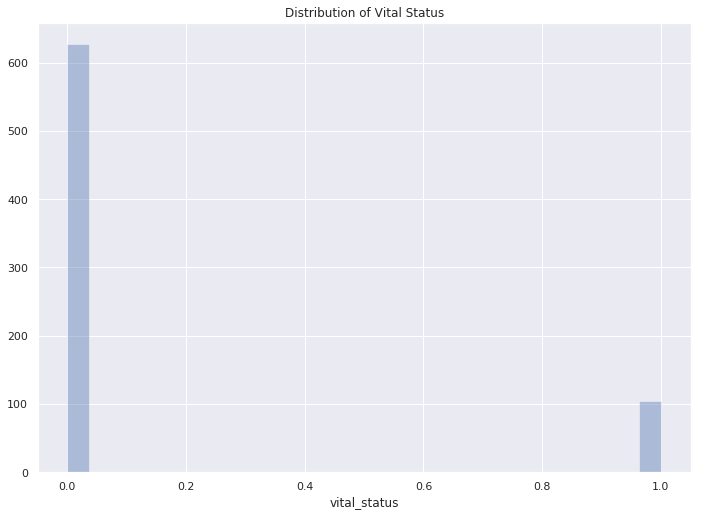

In [ ]:
sns.distplot(res['vital_status'], kde=False).set_title('Distribution of Vital Status')

#### A Little More Statistics

As noted earlier, since this is a classification problem, it is important to determine three metrics: precision, recall, and the F1 Score. The precision tells us of those that are labeled as dead are actually dead. The recall tells us of those who are actually dead, how many of those we correctly predicted. The F1 score is a metric that combines precision and recall into one statistics. Specificity is another metric to consider, and it tells us: of all the people are still alive, how many we correctly predicted. Accuracy measures how many classifications were correct. When it comes to binary classifications, especially with the skewed dataset we have, accuracy doesn't tell us much about the predictive power of our models. Rather, precision, recall, and the F1 score will tell us how good our models are at properly predicting a patient's vital status. The ROC curve AUC score is also a good metric to use to determine how good of a classifier our classifier is. An AUC closer to 0.5 means a classifier that is less able to make proper binary classifications. An AUC closer to 1 indicates a good binary classifier. 

In [ ]:
# Function to make the ROC curve. Encapsulating this within a function makes all
# following code cleaner.

def roc_maker(arch_str, y_pred, y_test):
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
    plt.legend(loc=4)
    plt.title(arch_str + ' ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Tue Positive Rate')
    plt.show()
    return None
    

In [ ]:
# Function to print important statistics

def stat_printer(y_test, y_pred):
  f1 = f1_score(y_test, y_pred, average='binary')
  recall = recall_score(y_test, y_pred, average='binary')
  precision = precision_score(y_test, y_pred, average='binary')
  accuracy = accuracy_score(y_test, y_pred)
  auc_roc = roc_auc_score(y_test, y_pred)
  metrics = ['F1 Score', 'Recall', 'Precision', 'Accuracy', 'AUC ROC']
  scores = [f1, recall, precision, accuracy, auc_roc]
  stat_df = pd.DataFrame(list(zip(metrics, scores)), 
               columns =['Metric', 'Score']) 
  display(stat_df)
  return None

#### Preliminary Model Testing Function

In [ ]:
# This function accepts the features (X), the labels (y), the test size for 
# train/test split, and a random_state if you choose to supply it.

def preliminary_testing(X, y, test_size, random_state=0):
    # Train test split with stratification of labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Initialize lists to hold models and metrics
    premodels = []
    model_names = []
    f1_scores = []
    recalls = []
    precisions = []
    accuracies = []
    auc = []
    
    # Initialize and add models to premodels list
    premodels.append(('K-NearestNeighbors', KNeighborsClassifier()))
    premodels.append(('SVC', SVC()))
    premodels.append(('LogisticRegression', LogisticRegression()))
    premodels.append(('DecisionTree', DecisionTreeClassifier()))
    premodels.append(('GaussianNaiveBayes', GaussianNB()))
    premodels.append(('RandomForest', RandomForestClassifier()))
    premodels.append(('GradientBoosting', GradientBoostingClassifier()))
    premodels.append(('MLPClassifier', MLPClassifier()))
    
    # Iteratively call each model and append metrics to corresponding lists
    for name, premodel in premodels:
        premodel.fit(X_train, y_train)
        y_pred = premodel.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred, average='binary'))
        recalls.append(recall_score(y_test, y_pred, average='binary'))
        precisions.append(precision_score(y_test, y_pred, average='binary'))
        auc.append(roc_auc_score(y_test, y_pred))
        accuracies.append(accuracy_score(y_test, y_pred))
        model_names.append(name)
        
    # Make dataframe of each model's performance and return it    
    preliminary_test = pd.DataFrame({'Model Name': model_names, 'F1-Score': f1_scores, 'Recall':recalls, 'Precision':precisions, 'Accuracy':accuracies, 'AUC-ROC':auc})
    return preliminary_test

## Unbalanced Dataset

As was done in the original notebooks, both the unbalanced and balanced datasets were explored. We will do the same in this updated notebook. However, this time, we will explore the entirety of the unbalanced dataset first and then the entirety of the balanced dataset. 

In [ ]:
# Specify the variables and targets 
X = res.drop(labels=['vital_status'], axis=1)
y = res[['vital_status']].values.ravel()

In [ ]:
# Now, we will do preliminary model testing. This a good approach to take that enables one to determine which 
# models may be best to use for any application. Although, we are only attempting to see how our models 
# perform, this is useful to perform before optimizing moving forward. 
splits = [.1, .2, .3]
for i in splits:
    prelims = preliminary_testing(X, y, i, 42)
    print(f"With a training size of {(1-i)*100}%, we get the following results")
    display(prelims)
    print("_"*80 + '\n')

With a training size of 90.0%, we get the following results


,Model Name,F1-Score,Recall,Precision,Accuracy,AUC-ROC
0,K-NearestNeighbors,0.000000,0.000000,0.000000,0.810811,0.476190
1,SVC,0.400000,0.272727,0.750000,0.878378,0.628427
2,LogisticRegression,0.000000,0.000000,0.000000,0.851351,0.500000
3,DecisionTree,0.695652,0.727273,0.666667,0.905405,0.831890
4,GaussianNaiveBayes,0.428571,0.272727,1.000000,0.891892,0.636364
5,RandomForest,0.444444,0.363636,0.571429,0.864865,0.658009
6,GradientBoosting,0.500000,0.363636,0.800000,0.891892,0.673882
7,MLPClassifier,0.000000,0.000000,0.000000,0.851351,0.500000


________________________________________________________________________________

With a training size of 80.0%, we get the following results


,Model Name,F1-Score,Recall,Precision,Accuracy,AUC-ROC
0,K-NearestNeighbors,0.080000,0.047619,0.250000,0.843537,0.511905
1,SVC,0.428571,0.285714,0.857143,0.891156,0.638889
2,LogisticRegression,0.000000,0.000000,0.000000,0.857143,0.500000
3,DecisionTree,0.487805,0.476190,0.500000,0.857143,0.698413
4,GaussianNaiveBayes,0.357143,0.238095,0.714286,0.877551,0.611111
5,RandomForest,0.424242,0.333333,0.583333,0.870748,0.646825
6,GradientBoosting,0.370370,0.238095,0.833333,0.884354,0.615079
7,MLPClassifier,0.000000,0.000000,0.000000,0.857143,0.500000


________________________________________________________________________________

With a training size of 70.0%, we get the following results


,Model Name,F1-Score,Recall,Precision,Accuracy,AUC-ROC
0,K-NearestNeighbors,0.181818,0.129032,0.307692,0.836364,0.540707
1,SVC,0.363636,0.258065,0.615385,0.872727,0.615805
2,LogisticRegression,0.000000,0.000000,0.000000,0.859091,0.500000
3,DecisionTree,0.424242,0.451613,0.400000,0.827273,0.670251
4,GaussianNaiveBayes,0.333333,0.225806,0.636364,0.872727,0.602321
5,RandomForest,0.181818,0.161290,0.208333,0.795455,0.530381
6,GradientBoosting,0.425532,0.322581,0.625000,0.877273,0.645417
7,MLPClassifier,0.000000,0.000000,0.000000,0.859091,0.500000


________________________________________________________________________________



As we can see, the accuracy for all models are very high. The only reason this is the case is that our dataset is heavily unblanced with many 0s. If most of our predictions are 0s and our test dataset is mostly 0s, then our accuracy really doesn't tell us how good our models are. Therefore, we should look at the F1 score, recall, and precision, all of which are fairly low or completely 0. This is due to the significant class imbalance in our dataset.

Additionally, even with a larger training size, all the models perform fairly poorly due to the large imbalance of classes. We will later see how this is solved after balancing our dataset.


Now, we will try to optimize each model independently and see if we can improve performance with our unbalanced dataset. 

#### Train-Test Split
We will use the same train test split for all the models. This will ensure that we use the same data points to train and test each model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify= y)

While testing, I recieved a lot of warnings. I checked through the warnings and ultimately found that the warnings didn't effect the results. Thus, to save space, I have turned warnings off henceforth.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

###### Important:

Some of these models with GridSearchCV take a very long time to run, sometimes on the order of many hours to nearly an entire day. If you are running this notebook on your own, make sure to keep that in mind. I highly recommend running these models using Google Colaboratory. It will save you a lot of time. 

Models that will take a while to run:
1) Decision Tree Classifier

2) Random Forest Classifier (> 12 Hours)

3) Gradient Boosting Classifier

4) MLP Classifier

The other models take from a few seconds to a minute to run. 



### K-Nearest Neighbors
#### Unbalanced Dataset




The best parameters found are: {'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}



,Metric,Score
0,F1 Score,0.555556
1,Recall,0.454545
2,Precision,0.714286
3,Accuracy,0.891892
4,AUC ROC,0.711400


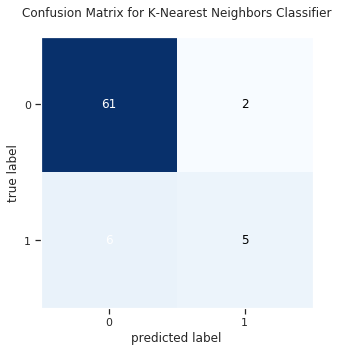



Here is the ROC Curve for the KNN Classifier


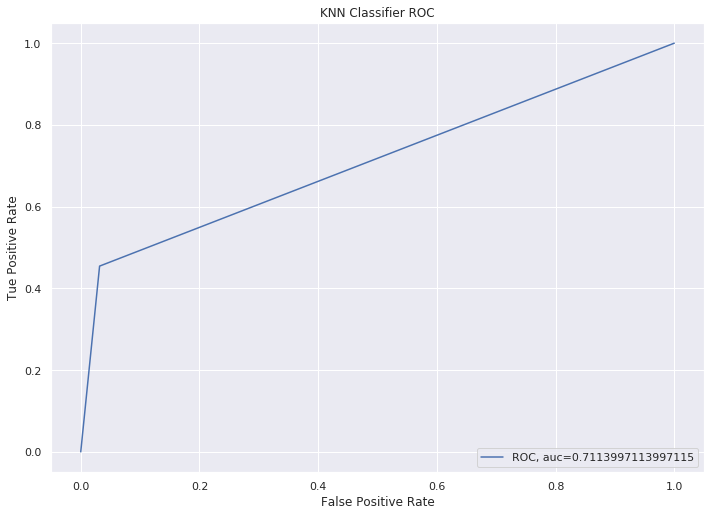

In [ ]:
# Parameter grid. Note that there may be other parameters to consider. However, I picked a subset of
# all parameters for all models in order to save computation time. 
param_grid = {
        'n_neighbors':[3, 4, 5, 6, 7, 8, 9, 10],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
        'leaf_size':[10, 20, 30, 40, 50, 60],
        'p': [1, 2],
        'metric':['l2', 'minkowski']
        }

    
# Initialize the classifier with the paramaters and cross validation 
knnbrs_cv = GridSearchCV(KNeighborsClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
knnbrs_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_knnbrs_cv = knnbrs_cv.best_estimator_
best_knnbrs_cv.fit(X_train, y_train)


# Test Accuracy
knnbrs_pred = best_knnbrs_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {knnbrs_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, knnbrs_pred)
print("\n")

#Confusion Matrix
knnbrs_cm = confusion_matrix(y_test, knnbrs_pred)
fig, ax = plot_confusion_matrix(conf_mat=knnbrs_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for K-Nearest Neighbors Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the KNN Classifier')
roc_maker('KNN Classifier', knnbrs_pred, y_test)


### SVC
#### Unbalanced Dataset




The best parameters found are: {'C': 1.0, 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'auto_deprecated', 'kernel': 'rbf', 'random_state': 42, 'tol': 0.01}



,Metric,Score
0,F1 Score,0.526316
1,Recall,0.454545
2,Precision,0.625000
3,Accuracy,0.878378
4,AUC ROC,0.703463


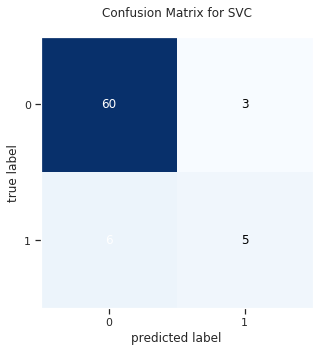



Here is the ROC Curve for the SVC


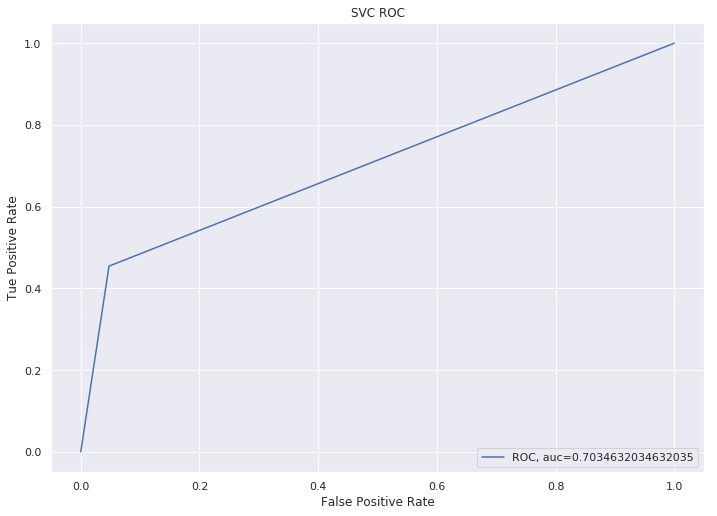

In [ ]:
# Parameter grid
param_grid = {
        'C':[1.0],
        'kernel': ['linear', 'rbf'],
        'degree':[2, 3],
        'gamma': ['scale', 'auto_deprecated'],
        'tol': [.01, .001, .0001],
        'class_weight': ['balanced'],
        'decision_function_shape': ['ovr'],
        'random_state':[42]
        }
    
# Initialize the classifier with the paramaters and cross validation 
svc_cv = GridSearchCV(SVC(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
svc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_svc_cv = svc_cv.best_estimator_
best_svc_cv.fit(X_train, y_train)


# Test Accuracy
svc_pred = best_svc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {svc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, svc_pred)
print("\n")

#Confusion Matrix
svc_cm = confusion_matrix(y_test, svc_pred)
fig, ax = plot_confusion_matrix(conf_mat=svc_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for SVC')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the SVC')
roc_maker('SVC', svc_pred, y_test)


### Logistic Regression Classification
#### Unbalanced Dataset

##### Using the l2 norm 




The best parameters found are: {'C': 3.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.1}



,Metric,Score
0,F1 Score,0.250000
1,Recall,0.272727
2,Precision,0.230769
3,Accuracy,0.756757
4,AUC ROC,0.556999


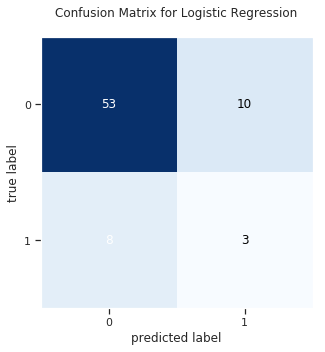



Here is the ROC Curve for the Logistic Regression (L2 Penalty)


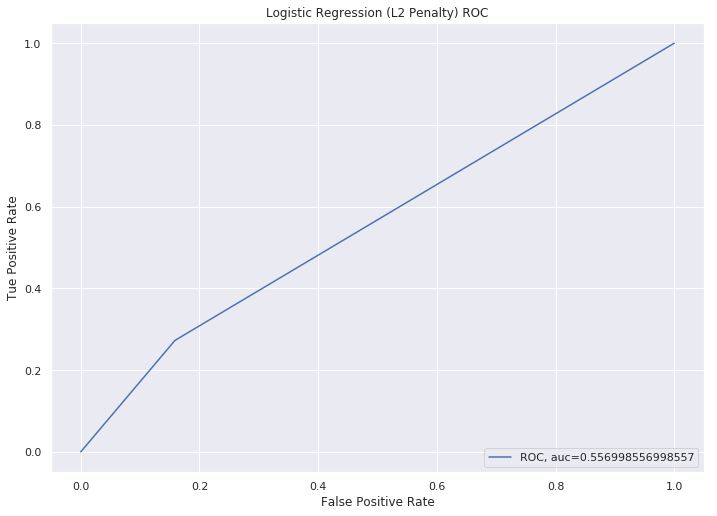

In [ ]:
# Parameter grid
param_grid = {
        'penalty':['l2'],
        'dual': [False],
        'tol': [.1, .01, .001, .0001, .00001],
        'C':[1.0, 3.0, 5.0, 7.0, 9.0],
        'fit_intercept': [True, False],
        'intercept_scaling':[1.0, 2.0, 3.0, 4.0],
        'class_weight': ['balanced'],
        'random_state':[42],
        'solver' :['newton-cg', 'lbfgs', 'sag', 'saga'],
        'max_iter' :[100, 500, 1000],
        'multi_class' :['ovr']
        }

    
# Initialize the classifier with the paramaters and cross validation 
logr_cv = GridSearchCV(LogisticRegression(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
logr_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_logr_cv = logr_cv.best_estimator_
best_logr_cv.fit(X_train, y_train)


# Test Accuracy
logr_pred = best_logr_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {logr_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, logr_pred)
print("\n")

#Confusion Matrix
logr_cm = confusion_matrix(y_test, logr_pred)
fig, ax = plot_confusion_matrix(conf_mat=logr_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Logistic Regression')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the Logistic Regression (L2 Penalty)')
roc_maker('Logistic Regression (L2 Penalty)', logr_pred, y_test)

##### Using the l1 norm




The best parameters found are: {'C': 3.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 3.0, 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.01}



,Metric,Score
0,F1 Score,0.250000
1,Recall,0.272727
2,Precision,0.230769
3,Accuracy,0.756757
4,AUC ROC,0.556999


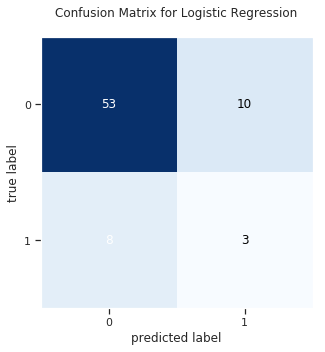



Here is the ROC Curve for the Logistic Regression (L1 Penalty)


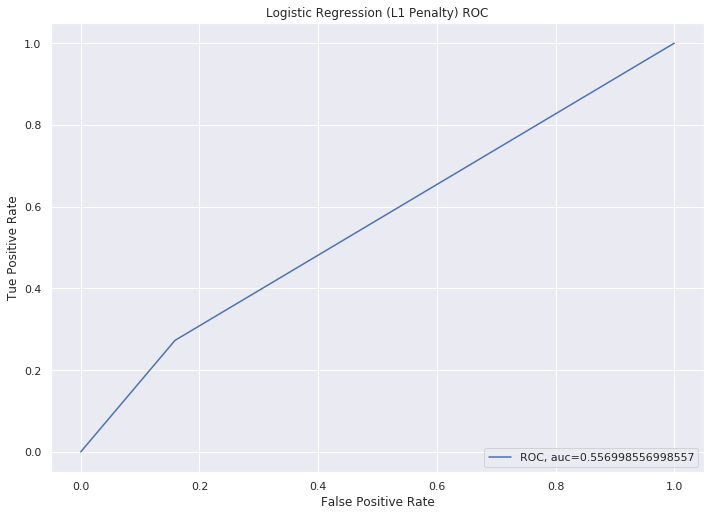

In [ ]:
# Parameter grid
param_grid = {
        'penalty':['l1'],
        'dual': [False],
        'tol': [.1, .01, .001, .0001, .00001],
        'C':[1.0, 3.0, 5.0, 7.0, 9.0],
        'fit_intercept': [True, False],
        'intercept_scaling':[1.0, 2.0, 3.0, 4.0],
        'class_weight': ['balanced', None],
        'random_state':[42],
        'solver' :['liblinear', 'saga'],
        'max_iter' :[100, 500, 1000],
        'multi_class' :['ovr']
        }

    
# Initialize the classifier with the paramaters and cross validation 
logr_cv = GridSearchCV(LogisticRegression(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
logr_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_logr_cv = logr_cv.best_estimator_
best_logr_cv.fit(X_train, y_train)


# Test Accuracy
logr_pred = best_logr_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {logr_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, logr_pred)
print("\n")

#Confusion Matrix
logr_cm = confusion_matrix(y_test, logr_pred)
fig, ax = plot_confusion_matrix(conf_mat=logr_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Logistic Regression')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the Logistic Regression (L1 Penalty)')
roc_maker('Logistic Regression (L1 Penalty)', logr_pred, y_test)

### Decision Tree Classifier
#### Unbalanced Datatset




The best parameters found are: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.1, 'presort': True, 'splitter': 'best'}



,Metric,Score
0,F1 Score,0.000000
1,Recall,0.000000
2,Precision,0.000000
3,Accuracy,0.851351
4,AUC ROC,0.500000


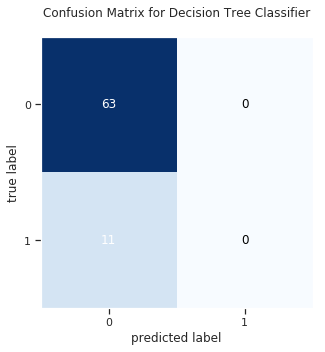



Here is the ROC Curve for the Decision Tree Classifier


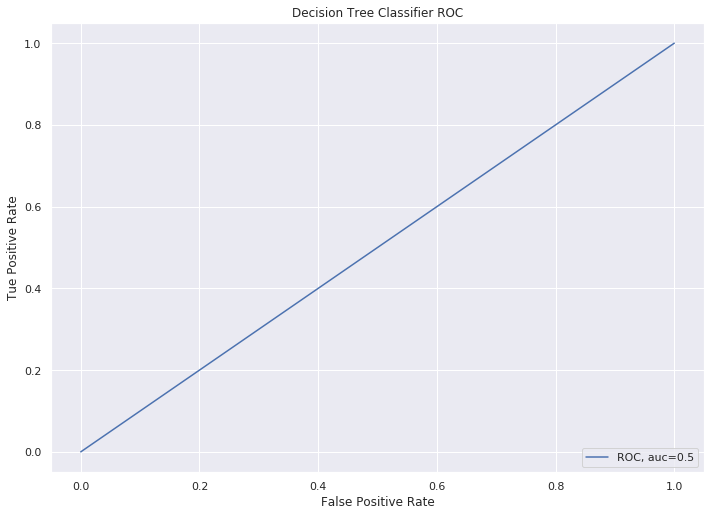

In [ ]:
# Parameter grid
param_grid = {
        'criterion':['gini', 'entropy'],
        'splitter': ['best'],
        'max_depth': [1, 3, 5, 7, 9, None],
        'min_samples_split':[0.1, 0.2, 0.3, 0.4, 0.5],
        'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5],
        'min_weight_fraction_leaf':[0.1, 0.2, 0.3, 0.4, 0.5],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_impurity_decrease' :[0., 1.0, 2.0, 3.0, 4.0],
        'presort' :[True, False]
        }

    
# Initialize the classifier with the paramaters and cross validation 
dtc_cv = GridSearchCV(DecisionTreeClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
dtc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_dtc_cv = dtc_cv.best_estimator_
best_dtc_cv.fit(X_train, y_train)


# Test Accuracy
dtc_pred = best_dtc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {dtc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, dtc_pred)
print("\n")

#Confusion Matrix
dtc_cm = confusion_matrix(y_test, dtc_pred)
fig, ax = plot_confusion_matrix(conf_mat=dtc_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the Decision Tree Classifier')
roc_maker('Decision Tree Classifier', dtc_pred, y_test)

### Gaussian Naive Bayes
#### Unbalanced Dataset




The best parameters found are: {'var_smoothing': 1e-09}



,Metric,Score
0,F1 Score,0.428571
1,Recall,0.272727
2,Precision,1.000000
3,Accuracy,0.891892
4,AUC ROC,0.636364


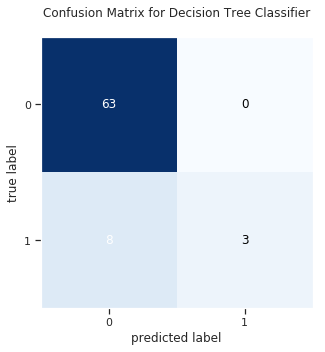



Here is the ROC Curve for Gaussian Naive Bayes


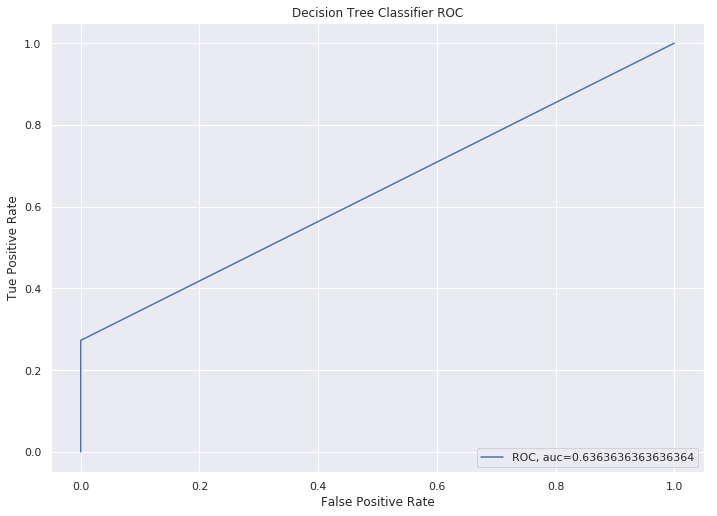

In [ ]:
# Parameter grid
param_grid = {
        'var_smoothing': [1e-9, 1e-7, 1e-5, 1e-3, 1e-1]
        }

    
# Initialize the classifier with the paramaters and cross validation 
gnb_cv = GridSearchCV(GaussianNB(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
gnb_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_gnb_cv = gnb_cv.best_estimator_
best_gnb_cv.fit(X_train, y_train)


# Test Accuracy
gnb_pred = best_gnb_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {gnb_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, gnb_pred)
print("\n")

#Confusion Matrix
gnb_cm = confusion_matrix(y_test, gnb_pred)
fig, ax = plot_confusion_matrix(conf_mat=gnb_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Gaussian Naive Bayes Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for Gaussian Naive Bayes')
roc_maker('Gaussian Naive Bayes Classifier', gnb_pred, y_test)

### Random Forest Classifier
#### Unbalaced Dataset




The best parameters found are: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 500, 'oob_score': True, 'random_state': 42}



,Metric,Score
0,F1 Score,0.526316
1,Recall,0.454545
2,Precision,0.625000
3,Accuracy,0.878378
4,AUC ROC,0.703463


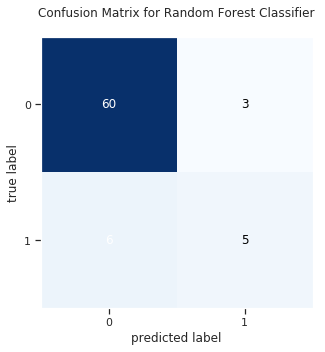



Here is the ROC Curve for the Random Forest Classifier


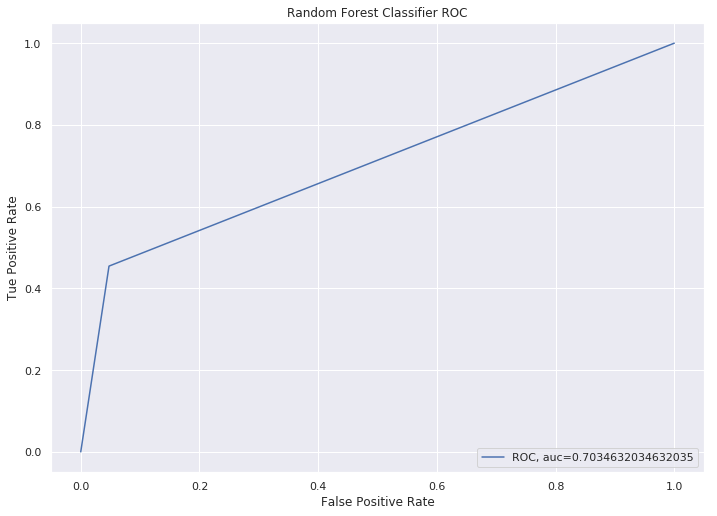

In [ ]:
# Parameter grid
param_grid = {
        'n_estimators': [100, 500],
        'criterion':['gini', 'entropy'],
        'max_depth': [1, 3, 5, None],
#         'min_samples_split':[0.1, 0.3, 0.5],
#         'min_samples_leaf': [0.1, 0.3, 0.5],
#         'min_weight_fraction_leaf':[0.1, 0.3, 0.5],
        'max_features': ['auto', 'sqrt', 'log2'],
#         'min_impurity_decrease' :[0., 1.0, 2.0],
        'bootstrap': [True],
        'oob_score': [True, False],
        'random_state':[42],
#         'warm_start': [True, False],
#         'class_weight': [None, 'balanced', 'balanced_subsample']
        }

    
# Initialize the classifier with the paramaters and cross validation 
rfc_cv = GridSearchCV(RandomForestClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
rfc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_rfc_cv = rfc_cv.best_estimator_
best_rfc_cv.fit(X_train, y_train)


# Test Accuracy
rfc_pred = best_rfc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {rfc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, rfc_pred)
print("\n")


#Confusion Matrix
rfc_cm = confusion_matrix(y_test, rfc_pred)
fig, ax = plot_confusion_matrix(conf_mat=rfc_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the Random Forest Classifier')
roc_maker('Random Forest Classifier', rfc_pred, y_test)

### Gradient Boosting Classifier
#### Unbalanced Dataset




The best parameters found are: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 1000, 'subsample': 0.6}



,Metric,Score
0,F1 Score,0.700000
1,Recall,0.636364
2,Precision,0.777778
3,Accuracy,0.918919
4,AUC ROC,0.802309


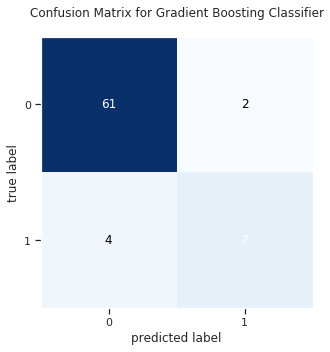



Here is the ROC Curve for the Gradient Boosting Classifier


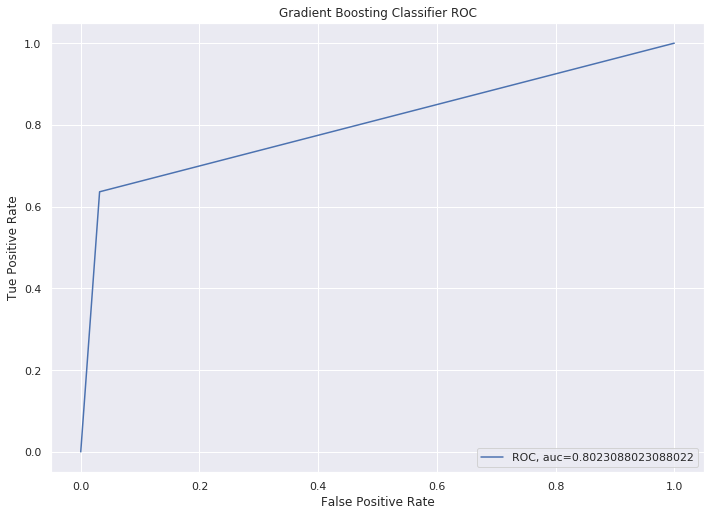

In [ ]:
# Parameter grid
param_grid = {
        'loss': ['deviance'],
        'learning_rate': [.1, .01],
        'n_estimators': [100, 1000],
        'subsample':[0.2, 0.6],
        'criterion': ['friedman_mse', 'mse'],
#         'min_samples_split':[1.0, 2.0, 3.0],
#         'min_samples_leaf': [1.0, 2.0, 3.0],
#         'min_weight_fraction_leaf':[0., 1.0, 2.0],
        'max_depth': [1, 3,5],
#        'min_impurity_decrease' :[0., 1.0, 2.0],
#        'init':[None, 'zero'],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_leaf_nodes' :[None],
#         'warm_start': [True, False],
#        'presort': [True, False, 'auto']
        }

    
# Initialize the classifier with the paramaters and cross validation 
gbc_cv = GridSearchCV(GradientBoostingClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
gbc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_gbc_cv = gbc_cv.best_estimator_
best_gbc_cv.fit(X_train, y_train)


# Test Accuracy
gbc_pred = best_gbc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {gbc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, gbc_pred)
print("\n")


#Confusion Matrix
gbc_cm = confusion_matrix(y_test, gbc_pred)
fig, ax = plot_confusion_matrix(conf_mat=gbc_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Gradient Boosting Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the Gradient Boosting Classifier')
roc_maker('Gradient Boosting Classifier', gbc_pred, y_test)

### MLP Classifier
#### Unbalanced Dataset




The best parameters found are: {'activation': 'tanh', 'alpha': 0.1, 'batch_size': 'auto', 'hidden_layer_sizes': (16,), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 1000, 'power_t': 0.1, 'random_state': 42, 'solver': 'adam', 'tol': 0.01}



,Metric,Score
0,F1 Score,0.000000
1,Recall,0.000000
2,Precision,0.000000
3,Accuracy,0.851351
4,AUC ROC,0.500000


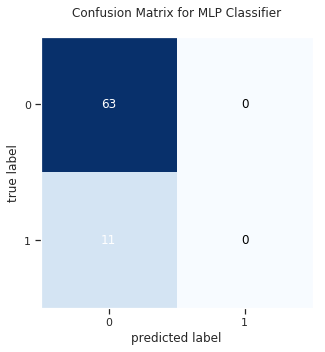



Here is the ROC Curve for the MLP Classifier


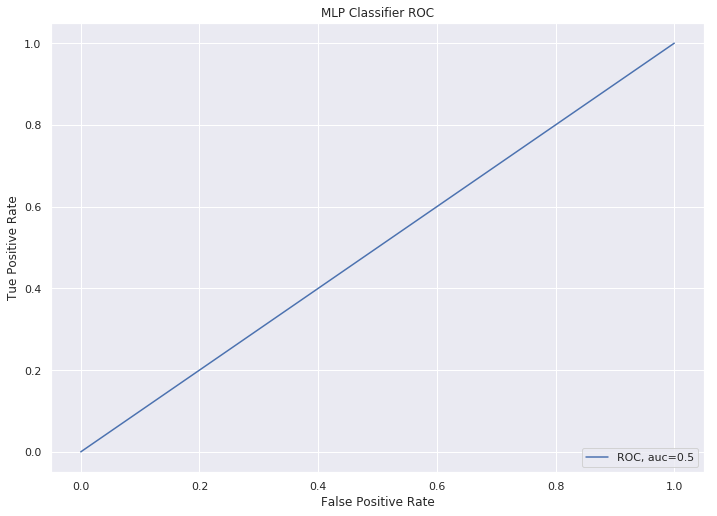

In [ ]:
# Parameter grid
param_grid = {
        'hidden_layer_sizes': [(64,), (32,), (16,)],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'adam'],
        'alpha':[.01, .1],
        'batch_size': ['auto'],
        'learning_rate':['constant', 'invscaling', 'adaptive'],
        'learning_rate_init':[.001, .01],
        'power_t': [0.1, 0.9],
        'max_iter':[1000],
#         'shuffle': [True, False],
        'random_state':[42],
        'tol':[1e-4, 1e-2],
#         'warm_start': [True, False],
#         'momentum': [0.1, 0.5],
        }
    
# Initialize the classifier with the paramaters and cross validation 
mlp_cv = GridSearchCV(MLPClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
mlp_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_mlp_cv = mlp_cv.best_estimator_
best_mlp_cv.fit(X_train, y_train)


# Test Accuracy
mlp_pred = best_mlp_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {mlp_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, mlp_pred)
print("\n")


#Confusion Matrix
mlp_cm = confusion_matrix(y_test, mlp_pred)
fig, ax = plot_confusion_matrix(conf_mat=mlp_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for MLP Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the MLP Classifier')
roc_maker('MLP Classifier', mlp_pred, y_test)

### Gradient Boosting Machine with XGBOOST
#### Unbalanced Dataset

In [ ]:
'''In this section, we will use a gradient boosted model (xgboost) to see if you we can accurately determine
if a patient will survive their breast cancer based on their mutation status.'''

#First, we will specify our training and testing sets for our independent and dependent variables. Here the independent variable
#is the gene. We use the 'Hugo_Symbol' and 'tumor_stage' columns. The dependent variable is the vital_status of the patient.
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y) #want to use same state for proper
                                                                                               #comparison

In [ ]:
#Here, we apply the gradient boosted model
# for xgboost python API, we will need to first create a data class named `xgboost.DMatrix`
data = xgb.DMatrix(data=X_train, label=y_train)
xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "binary:hinge", #This is the objective used to perform binary classification
    "eval_metric": "error",
    "early_stopping_rounds": 10,
    "seed": 4060
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=1000)
cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=1000, nfold=5,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                               xgb.callback.early_stop(1000)])

In [ ]:
#Let's take the best iteration 
best_iter = cv_history["test-error-mean"].idxmin()
#Let's retrain based on the best iteration
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=best_iter)

A feature importance plot can be made to show how much more one feature is than the other. Here, we can see that the gene type is not nearly as important in predicting patient survival as the tumor stage is. This makes sense as survival depends more so on the progression of a cancer rather than on the mutated genes leading to cancer. 

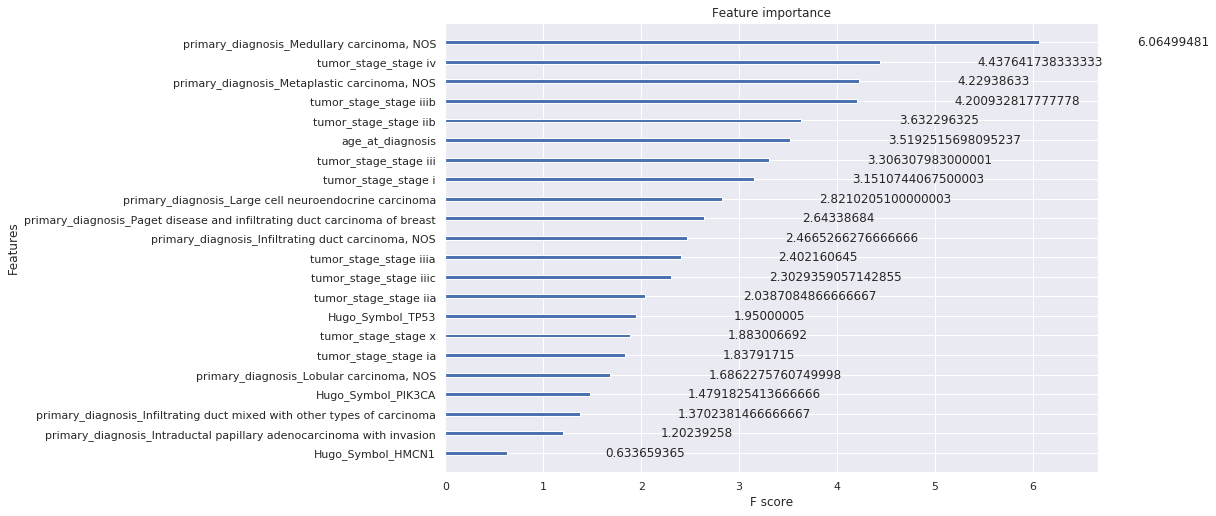

In [ ]:
#We can plot the F score of our genes
xgb.plot_importance(xgbmodel, importance_type='gain')

This diagram suggests that the most important features were not actually the mutation type, but rather the primary diagnosis of the cancer type and the tumor stage. Of the three gene mutations, the TP53 mutation appears to have the greatest impact on patient survival. The presence of medullary cacrcinoma seems to have the greatest impact on determining patient survival (dead or living). We will later see how this plot changes after balancing our dataset.

,Metric,Score
0,F1 Score,0.400000
1,Recall,0.272727
2,Precision,0.750000
3,Accuracy,0.878378
4,AUC ROC,0.628427


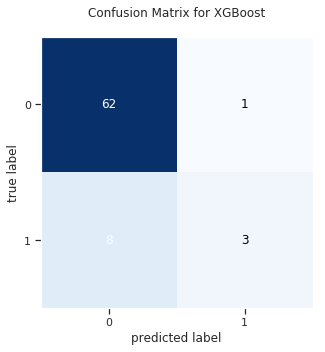



Here is the ROC Curve for XGB


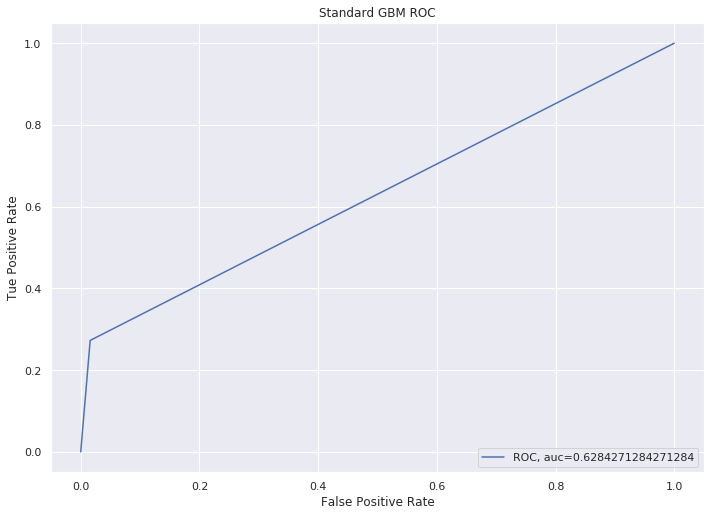

In [ ]:
#Let's do a prediction
xgb_pred = xgbmodel.predict(xgb.DMatrix(X_test))

# Print out dataframe of statistics
stat_printer(y_test, xgb_pred)
print("\n")

#Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_pred)
fig, ax = plot_confusion_matrix(conf_mat=xgb_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for XGBoost')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for XGB')
roc_maker('Standard GBM', xgb_pred, y_test)

### Keras Neural Network
#### Unbalanced Dataset

In [ ]:
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify= y)

In [3]:
''''We will be using the Sequential Model with the different activation functions, an
additional softmax layer, and an adaptive activation function, RMSprop.'''


model = Sequential()
model.add(Dense(200, activation='tanh', input_shape=(X_train.shape[1],))) #First layer with 64 units
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.33)) 
model.add(Dense(2, activation='softmax')) #Additional layer
model.compile(optimizer='rmsprop',     #Adapative optimizer
              loss='binary_crossentropy', #Binary classification
              metrics=['binary_accuracy'])

print("These are the layers of the model:")
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
These are the layers of the model:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               6800      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (Non

In [ ]:
# We can use early stopping to stop training when we begin to decrease in accuracy. I also pass patience to allow for small decreases
# before sharp increase in accuracy
es = EarlyStopping(monitor='binary_accuracy', mode='min', verbose=0, 
                   patience=900
                  )
batch_size = 32

# Save best model (will be saved in same directory location)
mc = ModelCheckpoint('best_model_breast.h5', monitor='binary_accuracy', mode='max', verbose=0, save_best_only=True)

Train Accuracry Score: 0.858, Test Accuracy Score: 0.851


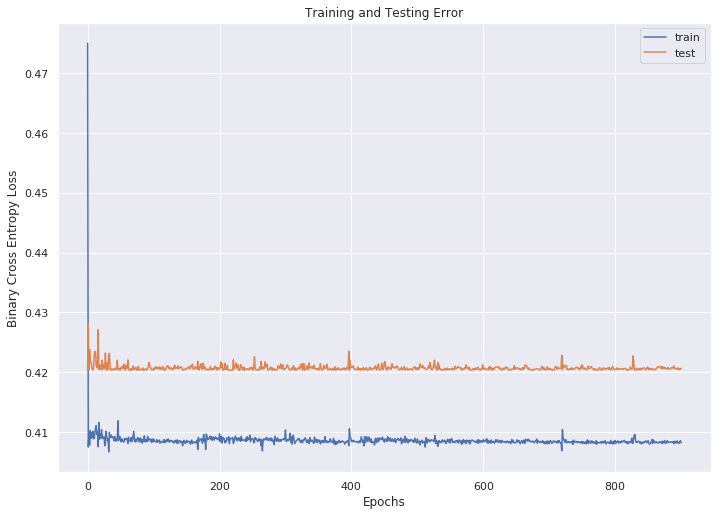

In [ ]:
# Run model
run_model = model.fit(X_train, y_train, 
                      batch_size=batch_size, 
                      validation_data=(X_test, y_test),
                      validation_split = 0.1,
                      shuffle = True,
                      epochs=1000, verbose=0, 
                      callbacks=[es, mc]
                   )

# Print results of model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train Accuracry Score: %.3f, Test Accuracy Score: %.3f' % (train_acc, test_acc))

# Plot training history of model
plt.plot(run_model.history['loss'], label='train')
plt.plot(run_model.history['val_loss'], label='test')
plt.title("Training and Testing Error")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.legend()
plt.show()

,Metric,Score
0,F1 Score,0.000000
1,Recall,0.000000
2,Precision,0.000000
3,Accuracy,0.851351
4,AUC ROC,0.500000


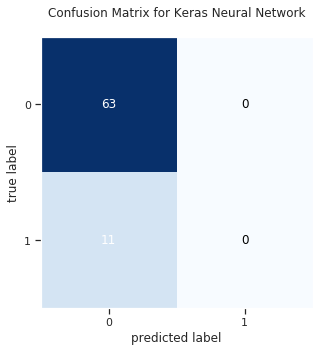



These are the statistics for the Keras Neural Network


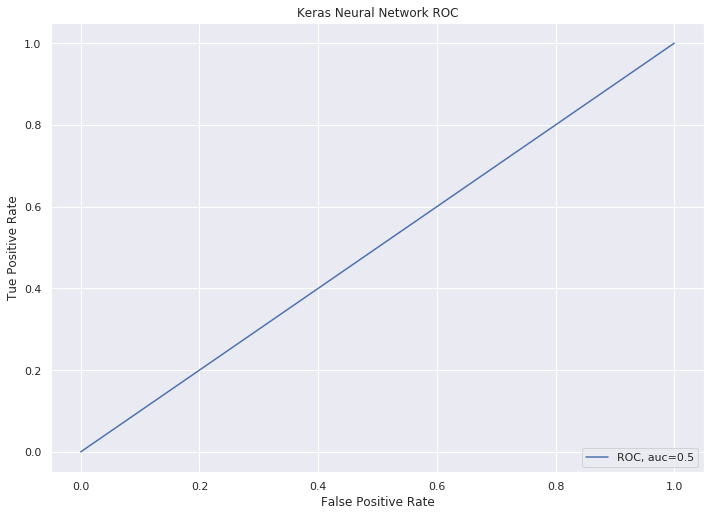

In [ ]:
#Make Predictions
model.load_weights('best_model_breast.h5')
y_keras = model.predict_classes(X_test)

#Reinitialize y_test for us in confusion matrix due to the mismatch in type of y_keras
y = res[['vital_status']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify= y)

# Print out dataframe of statistics
stat_printer(y_test, y_keras)
print("\n")

#Confusion Matrix
y_keras_cm = confusion_matrix(y_test, y_keras)
fig, ax = plot_confusion_matrix(conf_mat=y_keras_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Keras Neural Network')
plt.show()
print("\n")

# ROC Curve
print('These are the statistics for the Keras Neural Network')
roc_maker('Keras Neural Network', y_keras, y_test)

## Balancing 'vital_status' to make Balanced Dataset

One of the biggest issues of our dataset is how it has many more 0's than 1s, or more patients who remain living than who actually have passed. When using this unbalanced dataset to train our models, we are training them to be better at predicting for one label over another. Ideally, we want our models to be able to predict each label equally well. Since we have fewer 1s in our our "vital_status" field, we can use the number of 1s as the number of each label to ideally have. We will pick a random subset of the data points that have a "vital_status" of 0 and then combine that subset with all the data points with "vital_status" of 1. 

In [ ]:
res1 = res[res['vital_status'] == 1] #Given that 1 appears far less often, I will use the number of 'vital_status' = 1 as data length
res1len = len(res1)
res0 = res[res['vital_status'] ==0] # all 'vital_status' =0
res0 = res0.sample(n=res1len) # sample from all 'vital_status' = 0
equals = [res1, res0]
res_new = pd.concat(equals)
res_new = res_new.sample(frac=1) # our new dataset with equal number of 1s and 0s

### Machine Learning On Balanced Dataset

In [ ]:
# Specify the variables and targets 
X_bal = res_new.drop(labels=['vital_status'], axis=1)
y_bal = res_new[['vital_status']].values.ravel()

In [ ]:
# We will do some preliminary testing our balanced dataset. As before, we will cycle through three train-test 
# splits to see how model accuracy differs with each split. Given our small dataset size, we may see significant
# changes
splits = [.1, .2, .3]
for i in splits:
    prelims = preliminary_testing(X_bal, y_bal, i, 42)
    print(f"With a training size of {(1-i)*100}%, we get the following results")
    display(prelims)
    print("_"*80 + '\n')

With a training size of 90.0%, we get the following results


,Model Name,F1-Score,Recall,Precision,Accuracy,AUC-ROC
0,K-NearestNeighbors,0.842105,0.8,0.888889,0.857143,0.854545
1,SVC,0.842105,0.8,0.888889,0.857143,0.854545
2,LogisticRegression,0.782609,0.9,0.692308,0.761905,0.768182
3,DecisionTree,0.666667,0.7,0.636364,0.666667,0.668182
4,GaussianNaiveBayes,0.782609,0.9,0.692308,0.761905,0.768182
5,RandomForest,0.800000,0.8,0.800000,0.809524,0.809091
6,GradientBoosting,0.857143,0.9,0.818182,0.857143,0.859091
7,MLPClassifier,0.000000,0.0,0.000000,0.523810,0.500000


________________________________________________________________________________

With a training size of 80.0%, we get the following results


,Model Name,F1-Score,Recall,Precision,Accuracy,AUC-ROC
0,K-NearestNeighbors,0.697674,0.714286,0.681818,0.690476,0.690476
1,SVC,0.705882,0.571429,0.923077,0.761905,0.761905
2,LogisticRegression,0.578947,0.523810,0.647059,0.619048,0.619048
3,DecisionTree,0.702703,0.619048,0.812500,0.738095,0.738095
4,GaussianNaiveBayes,0.578947,0.523810,0.647059,0.619048,0.619048
5,RandomForest,0.648649,0.571429,0.750000,0.690476,0.690476
6,GradientBoosting,0.685714,0.571429,0.857143,0.738095,0.738095
7,MLPClassifier,0.666667,1.000000,0.500000,0.500000,0.500000


________________________________________________________________________________

With a training size of 70.0%, we get the following results


,Model Name,F1-Score,Recall,Precision,Accuracy,AUC-ROC
0,K-NearestNeighbors,0.590164,0.580645,0.600000,0.603175,0.602823
1,SVC,0.577778,0.419355,0.928571,0.698413,0.694052
2,LogisticRegression,0.615385,0.645161,0.588235,0.603175,0.603831
3,DecisionTree,0.741935,0.741935,0.741935,0.746032,0.745968
4,GaussianNaiveBayes,0.518519,0.451613,0.608696,0.587302,0.585181
5,RandomForest,0.610169,0.580645,0.642857,0.634921,0.634073
6,GradientBoosting,0.654545,0.580645,0.750000,0.698413,0.696573
7,MLPClassifier,0.000000,0.000000,0.000000,0.507937,0.500000


________________________________________________________________________________



We can already see increases in our metrics for multiple models. Although the balanced dataset does reduce the number of datapoints we have, we are able to make more balanced predictions. It is also clear that the amount of samples we train on significantly improve our model's performance on our testing set. Since we have the best performance with a 90/10 split, we will specify our train-test split as .1 (test set size).

#### Train-Test Split
We need to reperform our train-test split since we are working with a new dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.1, random_state=42, stratify = y_bal)

### K-Nearest Neighbors
#### Balanced Dataset




The best parameters found are: {'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'l2', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}


,Metric,Score
0,F1 Score,0.900000
1,Recall,0.900000
2,Precision,0.900000
3,Accuracy,0.904762
4,AUC ROC,0.904545


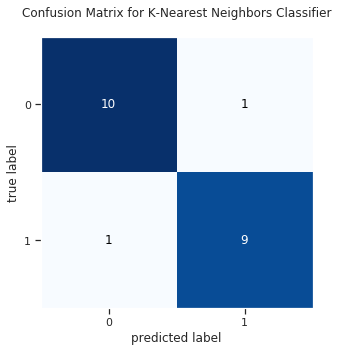



Here is the ROC Curve for the KNN Classifier


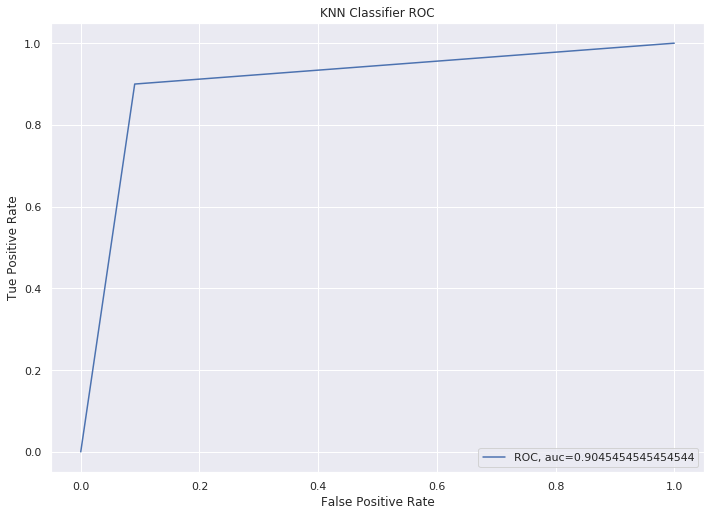

In [ ]:
# Parameter grid
param_grid = {
        'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
        'leaf_size':[10, 20, 30, 40, 50, 60],
        'p': [1, 2],
        'metric':['l2', 'minkowski']
        }

    
# Initialize the classifier with the paramaters and cross validation 
knnbrs_cv = GridSearchCV(KNeighborsClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
knnbrs_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_knnbrs_cv = knnbrs_cv.best_estimator_
best_knnbrs_cv.fit(X_train, y_train)


# Test Accuracy
knnbrs_pred = best_knnbrs_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {knnbrs_cv.best_params_}')

# Print out dataframe of statistics
stat_printer(y_test, knnbrs_pred)
print("\n")

#Confusion Matrix
knnbrs_cm = confusion_matrix(y_test, knnbrs_pred)
fig, ax = plot_confusion_matrix(conf_mat=knnbrs_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for K-Nearest Neighbors Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the KNN Classifier')
roc_maker('KNN Classifier', knnbrs_pred, y_test)

### SVC
#### Balanced Dataset




The best parameters found are: {'C': 1.0, 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'auto_deprecated', 'kernel': 'rbf', 'random_state': 42, 'tol': 0.01}



,Metric,Score
0,F1 Score,0.842105
1,Recall,0.800000
2,Precision,0.888889
3,Accuracy,0.857143
4,AUC ROC,0.854545


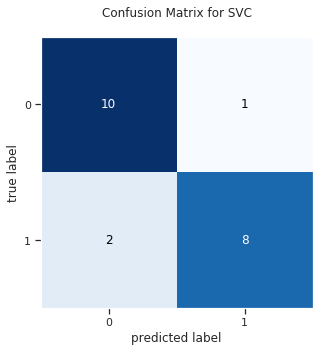



Here is the ROC Curve for the SVC


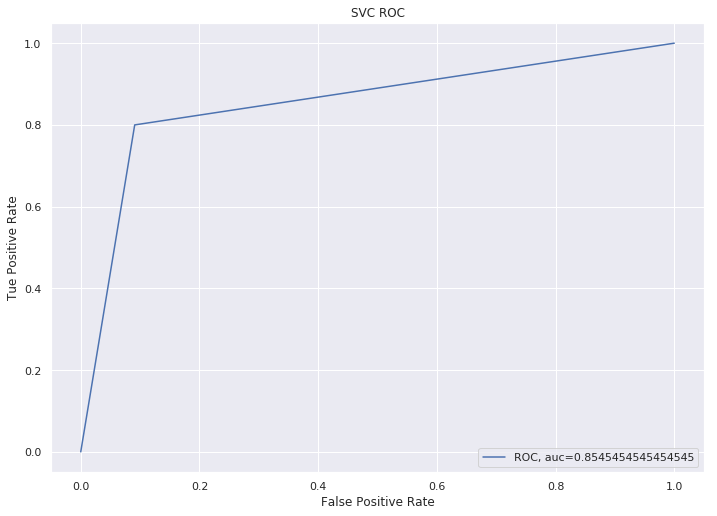

In [ ]:
# Parameter grid
param_grid = {
        'C':[1.0],
        'kernel': ['linear', 'rbf'],
        'degree':[2, 3],
        'gamma': ['scale', 'auto_deprecated'],
        'tol': [.01, .001, .0001],
        'class_weight': ['balanced'],
        'decision_function_shape': ['ovr'],
        'random_state':[42]
        }

    
# Initialize the classifier with the paramaters and cross validation 
svc_cv = GridSearchCV(SVC(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
svc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_svc_cv = svc_cv.best_estimator_
best_svc_cv.fit(X_train, y_train)


# Test Accuracy
svc_pred = best_svc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {svc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, svc_pred)
print("\n")

#Confusion Matrix
svc_cm = confusion_matrix(y_test, svc_pred)
fig, ax = plot_confusion_matrix(conf_mat=svc_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for SVC')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the SVC')
roc_maker('SVC', svc_pred, y_test)

### Logistic Regression Classification
#### Balanced Dataset

##### Using the l2 norm




The best parameters found are: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'tol': 0.1}



,Metric,Score
0,F1 Score,0.645161
1,Recall,1.000000
2,Precision,0.476190
3,Accuracy,0.476190
4,AUC ROC,0.500000


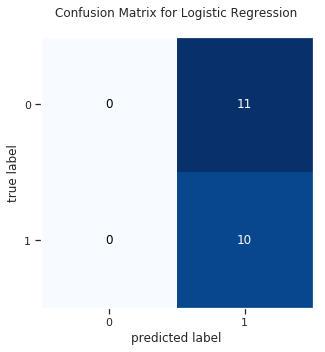



Here is the ROC Curve for the Logistic Regression (L2 Penalty)


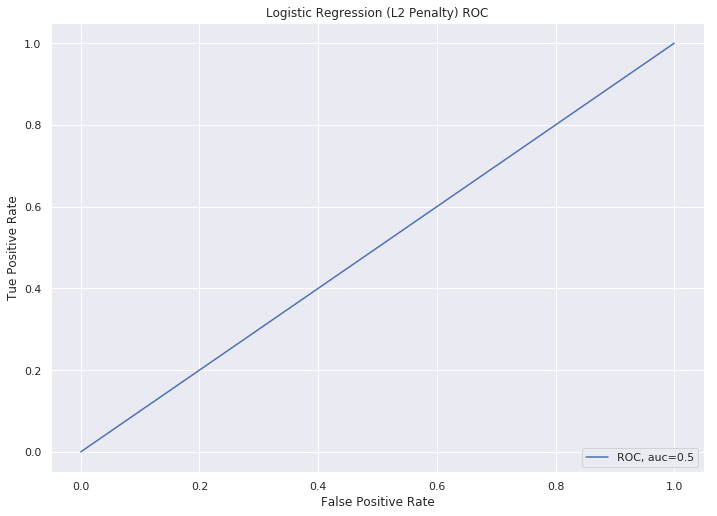

In [ ]:
# Parameter grid
param_grid = {
        'penalty':['l2'],
        'dual': [False],
        'tol': [.1, .01, .001, .0001, .00001],
        'C':[1.0, 3.0, 5.0, 7.0, 9.0],
        'fit_intercept': [True, False],
        'intercept_scaling':[1.0, 2.0, 3.0, 4.0],
        'class_weight': ['balanced', None],
        'random_state':[42, None],
        'solver' :['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear'],
        'max_iter' :[100, 500, 1000, 1500, 2000],
        'multi_class' :['ovr']
        }

    
# Initialize the classifier with the paramaters and cross validation 
logr_cv = GridSearchCV(LogisticRegression(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
logr_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_logr_cv = logr_cv.best_estimator_
best_logr_cv.fit(X_train, y_train)


# Test Accuracy
logr_pred = best_logr_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {logr_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, logr_pred)
print("\n")

#Confusion Matrix
logr_cm = confusion_matrix(y_test, logr_pred)
fig, ax = plot_confusion_matrix(conf_mat=logr_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Logistic Regression')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the Logistic Regression (L2 Penalty)')
roc_maker('Logistic Regression (L2 Penalty)', logr_pred, y_test)

##### Using the l1 norm




The best parameters found are: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.1}



,Metric,Score
0,F1 Score,0.645161
1,Recall,1.000000
2,Precision,0.476190
3,Accuracy,0.476190
4,AUC ROC,0.500000


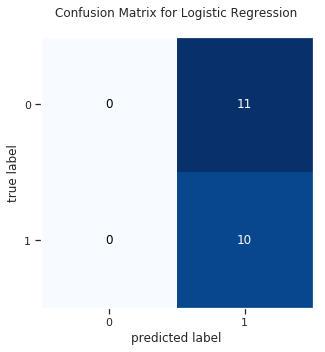



Here is the ROC Curve for the Logistic Regression (L1 Penalty)


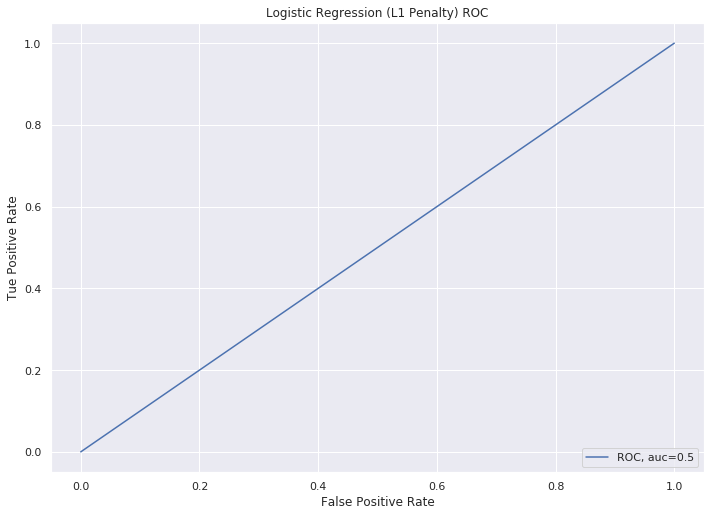

In [ ]:
# Parameter grid
param_grid = {
        'penalty':['l1'],
        'dual': [False],
        'tol': [.1, .01, .001, .0001, .00001],
        'C':[1.0, 3.0, 5.0, 7.0, 9.0],
        'fit_intercept': [True, False],
        'intercept_scaling':[1.0, 2.0, 3.0, 4.0],
        'class_weight': ['balanced', None],
        'random_state':[42],
        'solver' :['liblinear', 'saga'],
        'max_iter' :[100, 500, 1000, 1500, 2000],
        'multi_class' :['ovr']
        }

    
# Initialize the classifier with the paramaters and cross validation 
logr_cv = GridSearchCV(LogisticRegression(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
logr_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_logr_cv = logr_cv.best_estimator_
best_logr_cv.fit(X_train, y_train)


# Test Accuracy
logr_pred = best_logr_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {logr_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, logr_pred)
print("\n")

#Confusion Matrix
logr_cm = confusion_matrix(y_test, logr_pred)
fig, ax = plot_confusion_matrix(conf_mat=logr_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Logistic Regression')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the Logistic Regression (L1 Penalty)')
roc_maker('Logistic Regression (L1 Penalty)', logr_pred, y_test)

### Decision Tree Classifier
#### Balanced Dataset




The best parameters found are: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.1, 'presort': False, 'splitter': 'best'}



,Metric,Score
0,F1 Score,0.645161
1,Recall,1.000000
2,Precision,0.476190
3,Accuracy,0.476190
4,AUC ROC,0.500000


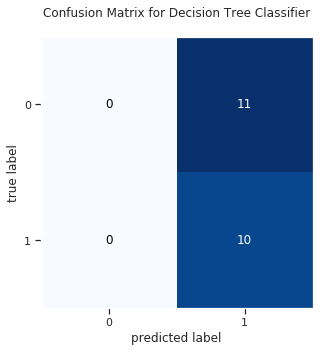



Here is the ROC Curve for the Decision Tree Classifier


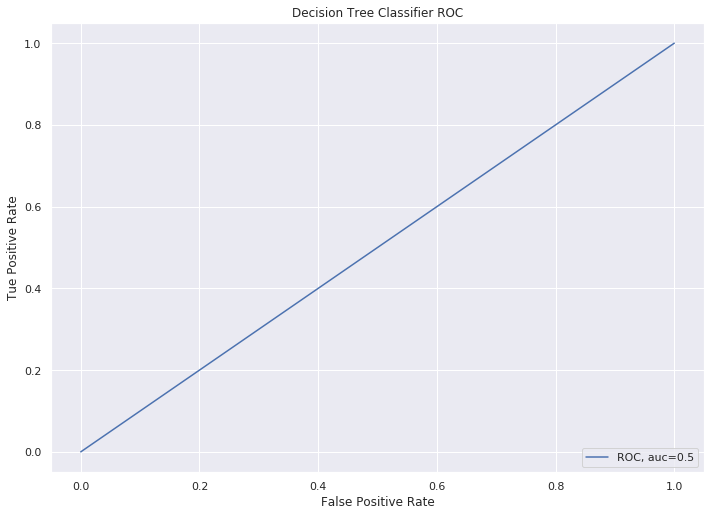

In [ ]:
# Parameter grid
param_grid = {
        'criterion':['gini', 'entropy'],
        'splitter': ['best'],
        'max_depth': [1, 3, 5, 7, 9, None],
        'min_samples_split':[0.1, 0.2, 0.3, 0.4, 0.5],
        'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5],
        'min_weight_fraction_leaf':[0.1, 0.2, 0.3, 0.4, 0.5],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_impurity_decrease' :[0., 1.0, 2.0, 3.0, 4.0],
        'presort' :[True, False]
        }

    
# Initialize the classifier with the paramaters and cross validation 
dtc_cv = GridSearchCV(DecisionTreeClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
dtc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_dtc_cv = dtc_cv.best_estimator_
best_dtc_cv.fit(X_train, y_train)


# Test Accuracy
dtc_pred = best_dtc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {dtc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, dtc_pred)
print("\n")

#Confusion Matrix
dtc_cm = confusion_matrix(y_test, dtc_pred)
fig, ax = plot_confusion_matrix(conf_mat=dtc_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the Decision Tree Classifier')
roc_maker('Decision Tree Classifier', dtc_pred, y_test)

### Gaussian Naive Bayes
#### Balanced Dataset




The best parameters found are: {'var_smoothing': 1e-09}



,Metric,Score
0,F1 Score,0.782609
1,Recall,0.900000
2,Precision,0.692308
3,Accuracy,0.761905
4,AUC ROC,0.768182


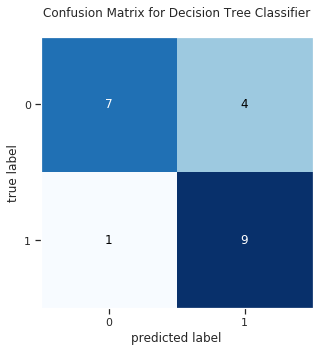



Here is the ROC Curve for Gaussian Naive Bayes


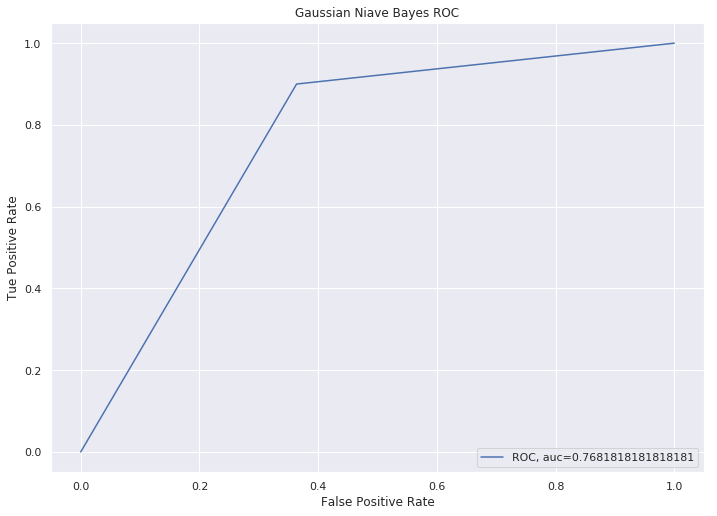

In [ ]:
# Parameter grid
param_grid = {
        'var_smoothing': [1e-9, 1e-7, 1e-5, 1e-3, 1e-1]
        }

    
# Initialize the classifier with the paramaters and cross validation 
gnb_cv = GridSearchCV(GaussianNB(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
gnb_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_gnb_cv = gnb_cv.best_estimator_
best_gnb_cv.fit(X_train, y_train)


# Test Accuracy
gnb_pred = best_gnb_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {gnb_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, gnb_pred)
print("\n")

#Confusion Matrix
gnb_cm = confusion_matrix(y_test, gnb_pred)
fig, ax = plot_confusion_matrix(conf_mat=gnb_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Gaussian Naive Bayes Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for Gaussian Naive Bayes')
roc_maker('Gaussian Niave Bayes', gnb_pred, y_test)

### Random Forest Classifier
#### Balaced Dataset




The best parameters found are: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100, 'oob_score': True, 'random_state': 42, 'warm_start': True}



,Metric,Score
0,F1 Score,0.761905
1,Recall,0.800000
2,Precision,0.727273
3,Accuracy,0.761905
4,AUC ROC,0.763636


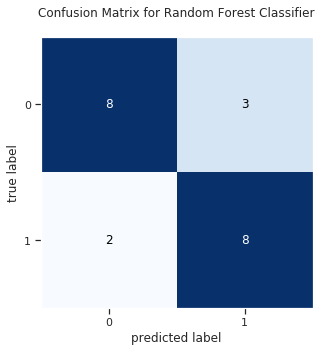



Here is the ROC Curve for the Random Forest Classifier


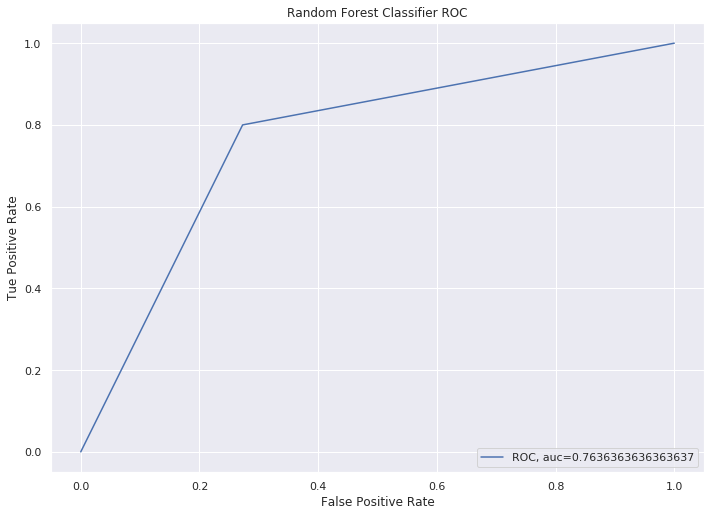

In [ ]:
# Parameter grid. 
param_grid = {
        'n_estimators': [100, 500],
        'criterion':['gini', 'entropy'],
        'max_depth': [1, 3, 5, None],
#         'min_samples_split':[0.1, 0.3, 0.5],
#         'min_samples_leaf': [0.1, 0.3, 0.5],
#         'min_weight_fraction_leaf':[0.1, 0.3, 0.5],
        'max_features': ['auto', 'sqrt', 'log2'],
#         'min_impurity_decrease' :[0., 1.0, 2.0],
        'bootstrap': [True],
        'oob_score': [True, False],
        'random_state':[42],
        'warm_start': [True, False],
        'class_weight': [None, 'balanced', 'balanced_subsample']
        }

    
# Initialize the classifier with the paramaters and cross validation 
rfc_cv = GridSearchCV(RandomForestClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
rfc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_rfc_cv = rfc_cv.best_estimator_
best_rfc_cv.fit(X_train, y_train)


# Test Accuracy
rfc_pred = best_rfc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {rfc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, rfc_pred)
print("\n")

#Confusion Matrix
rfc_cm = confusion_matrix(y_test, rfc_pred)
fig, ax = plot_confusion_matrix(conf_mat=rfc_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the Random Forest Classifier')
roc_maker('Random Forest Classifier', rfc_pred, y_test)

### Gradient Boosting Classifier
#### Balanced Dataset




The best parameters found are: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 1000, 'subsample': 0.2}



,Metric,Score
0,F1 Score,0.888889
1,Recall,0.800000
2,Precision,1.000000
3,Accuracy,0.904762
4,AUC ROC,0.900000


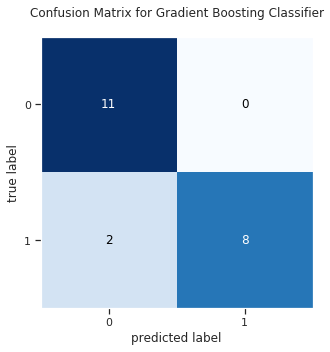



Here is the ROC Curve for the Gradient Boosting Classifier


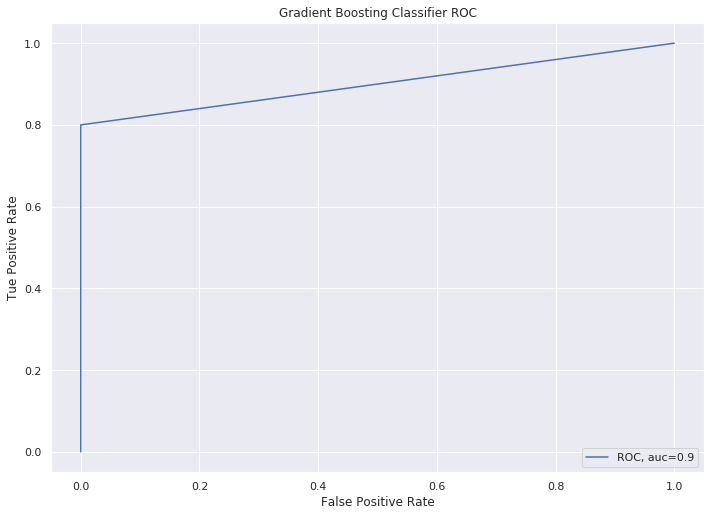

In [ ]:
# Parameter grid
param_grid = {
        'loss': ['deviance'],
        'learning_rate': [.1, .01, .001],
        'n_estimators': [100, 1000],
        'subsample':[0.2, 0.6],
        'criterion': ['friedman_mse', 'mse'],
#         'min_samples_split':[1.0, 2.0, 3.0],
#         'min_samples_leaf': [1.0, 2.0, 3.0],
#         'min_weight_fraction_leaf':[0., 1.0, 2.0],
        'max_depth': [1, 3,5],
#        'min_impurity_decrease' :[0., 1.0, 2.0],
#        'init':[None, 'zero'],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_leaf_nodes' :[None],
#         'warm_start': [True, False],
#        'presort': [True, False, 'auto']
        }

    
# Initialize the classifier with the paramaters and cross validation 
gbc_cv = GridSearchCV(GradientBoostingClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
gbc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_gbc_cv = gbc_cv.best_estimator_
best_gbc_cv.fit(X_train, y_train)


# Test Accuracy
gbc_pred = best_gbc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {gbc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, gbc_pred)
print("\n")

#Confusion Matrix
gbc_cm = confusion_matrix(y_test, gbc_pred)
fig, ax = plot_confusion_matrix(conf_mat=gbc_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Gradient Boosting Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the Gradient Boosting Classifier')
roc_maker('Gradient Boosting Classifier', gbc_pred, y_test)

### MLP Classifier
#### Balanced Dataset




The best parameters found are: {'activation': 'tanh', 'alpha': 0.01, 'batch_size': 'auto', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 500, 'power_t': 0.1, 'solver': 'lbfgs', 'tol': 0.0001}



,Metric,Score
0,F1 Score,0.645161
1,Recall,1.000000
2,Precision,0.476190
3,Accuracy,0.476190
4,AUC ROC,0.500000


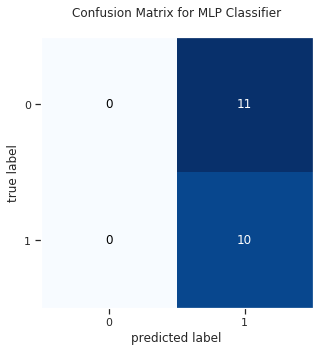



Here is the ROC Curve for the MLP Classifier


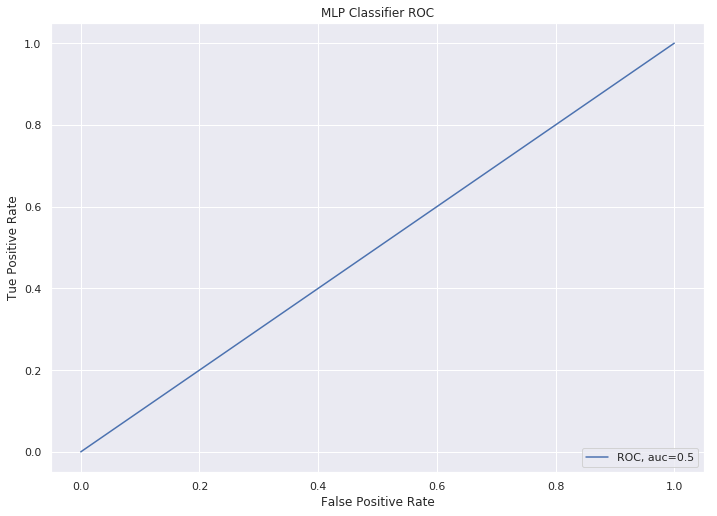

In [ ]:
# Parameter grid
param_grid = {
        'hidden_layer_sizes': [(100,), (200,), (300,)],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'adam'],
        'alpha':[.0001, .001, .01],
        'batch_size': ['auto'],
        'learning_rate':['constant', 'invscaling', 'adaptive'],
#         'learning_rate_init':[.0001, .001, .01],
        'power_t': [0.1, 0.5],
        'max_iter':[200, 500, 1000],
#         'shuffle': [True, False],
#         'random_state':[42],
        'tol':[1e-4, 1e-2],
#         'warm_start': [True, False],
#         'momentum': [0.1, 0.5],
        }

    
# Initialize the classifier with the paramaters and cross validation 
mlp_cv = GridSearchCV(MLPClassifier(),
              param_grid=param_grid,
              cv=3, scoring='f1', verbose=0)

# Train
mlp_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_mlp_cv = mlp_cv.best_estimator_
best_mlp_cv.fit(X_train, y_train)


# Test Accuracy
mlp_pred = best_mlp_cv.predict(X_test)
print('\n\n')
print(f'The best parameters found are: {mlp_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, mlp_pred)
print("\n")

#Confusion Matrix
mlp_cm = confusion_matrix(y_test, mlp_pred)
fig, ax = plot_confusion_matrix(conf_mat=mlp_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for MLP Classifier')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for the MLP Classifier')
roc_maker('MLP Classifier', mlp_pred, y_test)

### Gradient Boosting Machine with XGBOOST
#### Balanced Dataset

In [ ]:
'''In this section, we will use a gradient boosted model (xgboost) to see if you we can accurately determine
if a patient will survive their breast cancer based on their mutation status.'''

#First, we will specify our training and testing sets for our independent and dependent variables. Here the independent variable
#is the gene. We use the 'Hugo_Symbol' and 'tumor_stage' columns. The dependent variable is the vital_status of the patient.

y_bal=y_bal.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.1, random_state=42, stratify=y_bal) #want to use same state for proper
                                                                                               #comparison

In [ ]:
#Here, we apply the gradient boosted model
# for xgboost python API, we will need to first create a data class named `xgboost.DMatrix`
data = xgb.DMatrix(data=X_train, label=y_train)
xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 6,
    "objective": "binary:hinge", #This is the objective used to perform binary classification
    "eval_metric": "error",
    "early_stopping_rounds": 10,
    "seed": 4060
}

#Let's train our data set
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=1000)
cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=1000, nfold=5,
                    callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                               xgb.callback.early_stop(1000)])

In [ ]:
#Let's take the best iteration 
best_iter = cv_history["test-error-mean"].idxmin()
#Let's retrain based on the best iteration
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=best_iter)

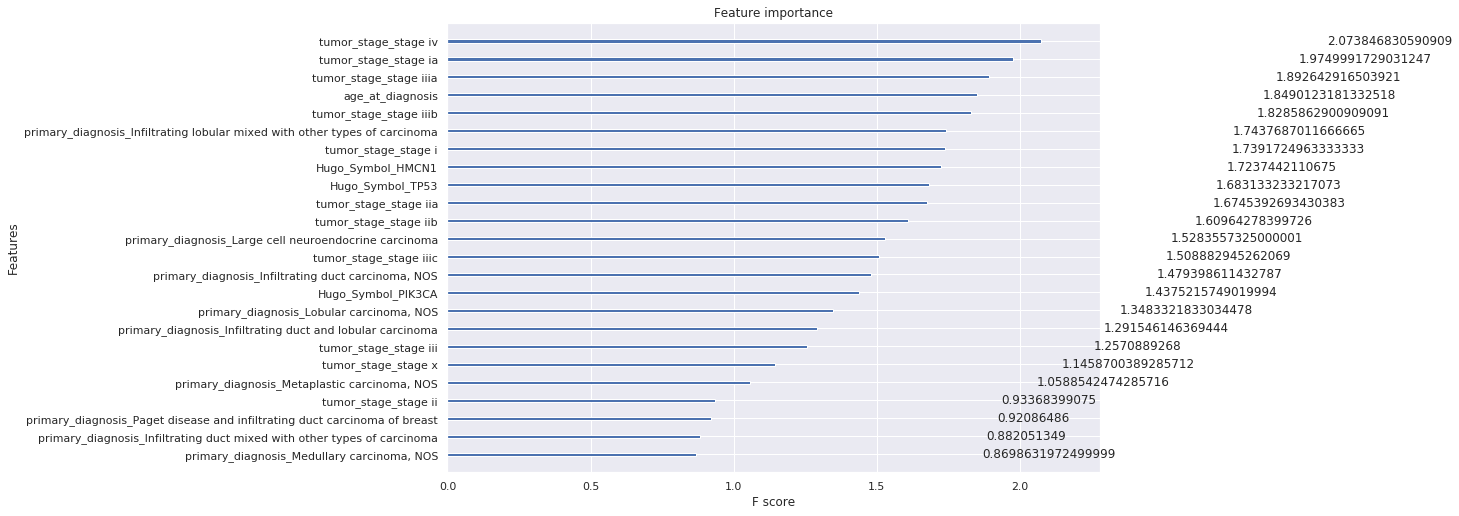

In [ ]:
#We can plot the F score of our genes
xgb.plot_importance(xgbmodel, importance_type='gain')

After balancing our dataset, we see that the presence of the HMCN1 gene mutation plays a greater role in predictions. This is remarkable since it previously had the lowest importance. This suggests that our previous feature importance plot was heavily impacted by the imbalance in our data. Notice how medullary carcinoma is the least important here. This may suggest that the importance of medullary carcinoma in our previous unbalanced dataset was influenced by the large number of 0s in that dataset. Now, we see the heavy influence of tymor stage over other features. 

,Metric,Score
0,F1 Score,0.823529
1,Recall,0.700000
2,Precision,1.000000
3,Accuracy,0.857143
4,AUC ROC,0.850000


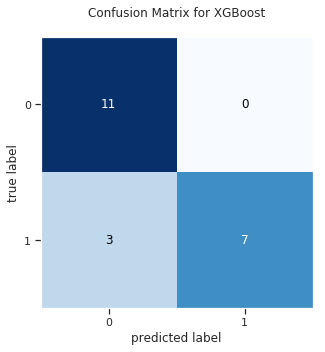



Here is the ROC Curve for XGB


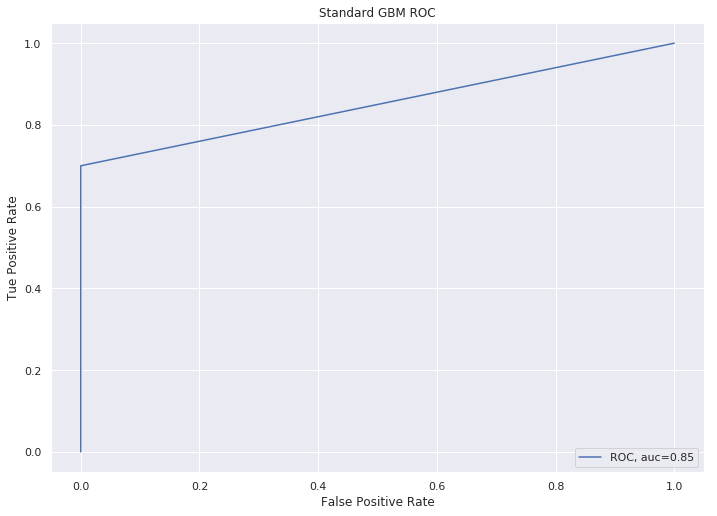

In [ ]:
#Let's do a prediction
xgb_pred = xgbmodel.predict(xgb.DMatrix(X_test))

# Print out dataframe of statistics
stat_printer(y_test, xgb_pred)
print("\n")


#Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_pred)
fig, ax = plot_confusion_matrix(conf_mat=xgb_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for XGBoost')
plt.show()
print("\n")

# ROC Curve
print('Here is the ROC Curve for XGB')
roc_maker('Standard GBM', xgb_pred, y_test)

### Keras Neural Network
#### Balanced Dataset

In [ ]:
y_bal = res_new[['vital_status']].values.ravel()
y_bal = to_categorical(y_bal)
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.1, random_state=42, stratify= y_bal)

In [ ]:
''''We will be using the Sequential Model with the tanh activation function, a layer of size 64 and a layer of size 2, an 
additional softmax layer, and an adaptive activation function, RMSprop. These choices are based on the GridSearchCV of the 
MLPClassifier without the balanced dataset'''


model = Sequential()
model.add(Dense(200, activation='tanh', input_shape=(X_train.shape[1],))) #First layer with 64 units
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.33)) 
model.add(Dense(2, activation='softmax')) #Additional layer
model.compile(optimizer='rmsprop',     #Adapative optimizer
              loss='binary_crossentropy', #Binary classification
              metrics=['binary_accuracy'])

print("These are the layers of the model:")
model.summary()

These are the layers of the model:
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 200)               6800      
_________________________________________________________________
dense_29 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_30 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 202       
Total params: 47,302
Trainable params: 47,302
Non-trainable params: 0
_______________

In [ ]:
# We can use early stopping to stop training when we begin to decrease in accuracy. I also pass patience to allow for small decreases
# before sharp increase in accuracy
es = EarlyStopping(monitor='binary_accuracy', mode='min', verbose=0, 
                   patience=900
                  )
batch_size = 32

# Save best model (will be saved in same directory location)
mc = ModelCheckpoint('best_model_breast.h5', monitor='binary_accuracy', mode='max', verbose=0, save_best_only=True)

Train Accuracry Score: 0.858, Test Accuracy Score: 0.851


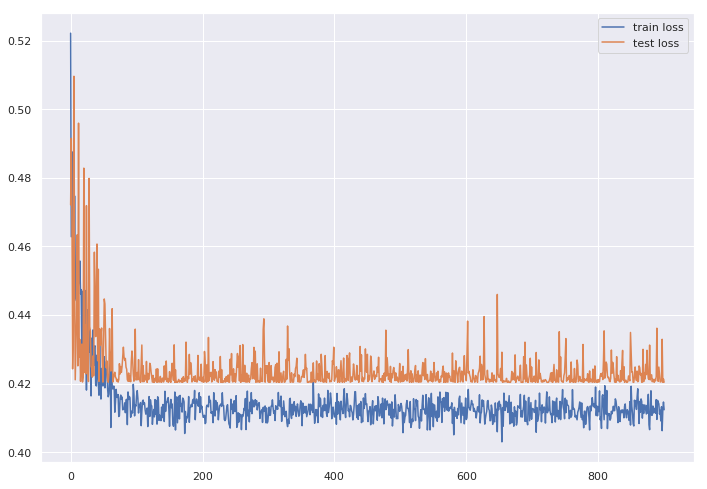

In [ ]:
# Run model
run_model = model.fit(X_train, y_train, 
                      batch_size=batch_size, 
                      validation_data=(X_test, y_test),
                      validation_split = 0.1,
                      shuffle = True,
                      epochs=1000, verbose=0, 
                      callbacks=[es, mc]
                   )


# Print results of model
_,train_acc = model.evaluate(X_train, y_train, verbose=0)
_,test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train Accuracry Score: %.3f, Test Accuracy Score: %.3f' % (train_acc, test_acc))

# Plot training history of model
plt.plot(run_model.history['loss'], label='train loss')
plt.plot(run_model.history['val_loss'], label='test loss')
plt.legend()
plt.show()

,Metric,Score
0,F1 Score,0.00000
1,Recall,0.00000
2,Precision,0.00000
3,Accuracy,0.52381
4,AUC ROC,0.50000


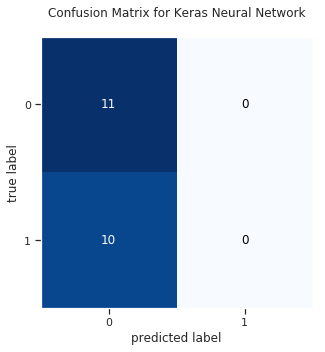



These are the statistics for the Keras Neural Network


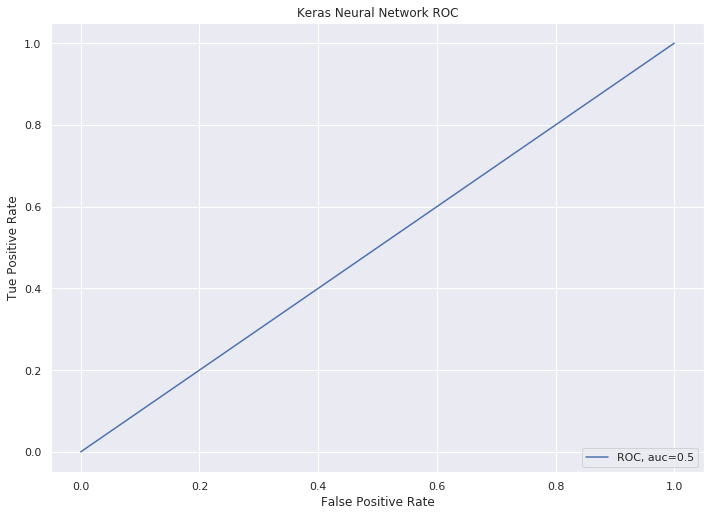

In [ ]:
#Make Predictions
model.load_weights('best_model_breast.h5')
y_keras = model.predict_classes(X_test)

#Reinitialize y_test for us in confusion matrix due to the mismatch in type of y_keras
y_bal = res_new[['vital_status']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.1, random_state=42, stratify= y_bal)

# Print out dataframe of statistics
stat_printer(y_test, y_keras)
print("\n")

#Confusion Matrix
y_keras_cm = confusion_matrix(y_test, y_keras)
fig, ax = plot_confusion_matrix(conf_mat=y_keras_cm ,  figsize=(5, 5))
plt.title('Confusion Matrix for Keras Neural Network')
plt.show()
print("\n")

# ROC Curve
print('These are the statistics for the Keras Neural Network')
roc_maker('Keras Neural Network', y_keras, y_test)

## Conclusions

### Survival Analysis

The survival analysis portion of this study demonstrated that the HMCN1 gene, although 10th most prevelant amongst the mutated genes prevelant amongst breast cancer patients, may actually be of significant interest to clincians. These mutated gene showed similar cumulative hazard and survival to a point compared to the cumulative hazard and survival of the TP53 and PIK3CA mutations for breast cancer patients. Thus, the data-driven analysis in this work verified the same observation regarding HMCN1 made by scientists in the lab. This highlights the value of data science in helping uncover or verify findings that ultimately impact patient care. 

### Machine Learning

The machine learning compononent of this project provided some interesting insights into how data composition can ultimately impact model strength. 

#### *Unbalanced Dataset*

For our unbalanced dataset, the Gradient Boosting Classifier, SVC, KNN, and Random Forest did fairly well, achieving AUC-ROC of .70 or higher. Of all these models, the Gradient Boosting Classifier performed really well with a F1 score of .70 and AUC-ROC of .80. This is quite remarkable given the heavy imbalance in our dataset. The general expectation for model performance is similar to how the other models performed. Thus, applying GridSearchCV helped determine the ideal parameters for some of the models to perform fairly well given the heavy class imbalance in our dataset. This is promising for practical use. Real world data often is imbalanced in nature. Although such data can always be balanced like it was in our case, it may not always be possible. For example, balancing may cause one to have very few data points to work with. Predictive models can definitely be made with a small number of data points, but they generally won't make consistently accurate predictions (prediction metric scores will vary significantly from test to test).

The neural network didn't perform well at all. It predicted all 'vital_status' as 0. This may in part be due to class imbalance. However, notice that even with a balanced dataset, we get similar results. The neural network consistently predicts the 'vital_status' as 0. 

#### *Balanced Dataset*

Balancing our dataset improved the performance of almost each of our models. With a balanced dataset, our Gradient Boosting, KNN, SVC, Gaussian Naive Bayes, Random Forest and XGBoost models achieved F1 scores and AUC-ROC scores of at least .70. In fact, the KNN, Graident Boosting, SVC, and XGBoost models each achieved F1 scores and AUC-ROC scores of .82 or higher. Both KNN and the Gradient Boosting classifiers achieved AUC-ROC of at least .90. This suggests that both models serve as nearly perfect binary classifiers for our dataset. Thus, if one were to predict patient survival using the same features that were used in this study, they should use the KNN classifier and Graident Boosting Classifier. However, given that the performance of the XGBoost model also improved significantly after balancing the dataset (from .628 AUC, .400 F1 score to .850 AUC, .824 F1 score), it should also be used to determine the important clinical features in making predcitions. In fact, balancing the dataset led to XGBoost placing more weight on features that it placed less weight on when trained on the unbalanced dataset. It captured the importance of tumor stage above gene mutation type and even gave more weight to the HMCN1 gene mutation than the TP53 and PIK3CA gene mutations. This could be due to the random sampling of the data points with an associated 'vital_status' of 0. In any case, the importance or weight of each mutation was fairly close. This points to our finding earlier with COX Regression Analysis- that each gene mutation has nearly the same impact on patient survival. 

We won't always have balanced data in the real world. If we do have an unbalanced dataset, we should always attempt to balance it. As indicated in this analysis, balancing a dataset significantly improves model performance.

#### *Overall*

Four models performed well with both datasets: Gradient Boosting, KNN, SVC, and Random Forest. With a balancd dataset, XGBoost performed really well. Graident Boosting performed better than KNN with the unbalanced dataset and KNN performed slightly better than Graident Boosting with the balanced dataset.

#### *Considerations*

When balancing our dataset, we sampled a random set of data points from our entire dataset to equalize the number of data points that have a 'vital_status' of 0 or 1. Performance of our model does change when sampling a different set of data points. This impact that random sampling has is decreased if we sample a greater number of data points. This finding follows the Central Limit Thereom, which states that the sampling distribution of the sample approaches a normal distribution as the sample size increases. In our case, some samples lead to a slight dip in models' performances. However, random sampling generally led close to the model performances shown here.

Before training each model with GridSearchCV, we iteratively applied our models with their standard parameters to perform preliminary model testing. Some models performed better with their default parameters than with the parameters determined by GridSearchCV (look at Logistic Regression with the balanced dataset). Thus, it is clear that for some models, default parameters are ideal. 

Our train-test split also impacted our model performance. During our preliminary model testing step, we noticed that performance generally dropped for many of the models with increases in testing size (which means smalller training size). This is expected in most cases, but even more so with our small dataset size of less than 1000 patients. The more data our models can train with, the better it can predict our labels. It is important to realize that the train-test split is randomized using a designated seed (42). Changing this random seed value will impact how our data is sampled into training and test sets. However, I have noticed that it doesn't change model performances siginificantly in our case with our dataset. 

Standardization: notice that we didn't standardize our dataset in this notebook. I made a seperate notebook (can be found in the iterations folder) that contains standardization. Standardization generally led to lower model performance.

#### *Future Work*

The next step is to apply this current notebook to the skin cancer dataset as well other datasets. There are definitely improvements to be made to some of the models in this analysis, particularly the neural network. We should also examine the feature importances determined by some of other models, like the Random Forest. We should explore the coefficients determined by logistic regression. I will continue to update the repository with future work.


## References
[1] Li, G., Guo, X., Chen, M., Tang, L., Jiang, H., Day, J. X., . . . Wang, J. (2018). Prevalence and spectrum of AKT1, PIK3CA, PTEN and TP53 somatic mutations in Chinese breast cancer patients. Plos One, 13(9). doi:10.1371/journal.pone.0203495

[2] Kikutake, C., Yoshihara, M., Sato, T., Saito, D., & Suyama, M. (2018). Intratumor heterogeneity of HMCN1 mutant alleles associated with poor prognosis in patients with breast cancer. Oncotarget, 9(70). doi:10.18632/oncotarget.26071

